Root Mean Square Flactuation (RMSF)

RMSF is a measure of the deviation of the position of a particle i with respect to a reference position **over time**.

**Difference between RMSD and RMSF**: The latter is averaged over time, giving a value for each particle i. For the RMSD the average is taken over the particles, giving time specific values. So **RMSD is time specific** and **RMSF is atom specific** [(ref)](http://www.drugdesign.gr/uploads/7/6/0/2/7602318/lecture_mdanalysis.pdf).

\begin{equation*}
RMSF_i = \left[ \frac{1}{T} \sum_{t_j=1}^T \mid r_i(t_j) - r_i^\text{ref} \mid ^ 2 \right] ^ \frac{1}{2}
\end{equation*}

$T$ is the total simulation time  
$r_i^\text{ref}$ is the reference position of particle $i$, eg. the **time-averaged** position of the same particle $i$  
$\mid r_i(t_j) - r_i^\text{ref} \mid$ is the Euclidean distance of particle $i$ on frame $j$ from $r_i^\text{ref}$

This time since our $x-axis$ are the residue ids, we will have a slightly different approach.
Our $y-axis$ will have the RMSF value of the residues specified by the $x-axis$.

In [6]:
import MDAnalysis
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.analysis import contacts
from MDAnalysis.analysis.align import AlignTraj 
import MDAnalysis.analysis.pca as pca
import MDAnalysis.analysis.distances as dist_analysis

from MDSimsEval.AnalysisActorClass import AnalysisActor
from MDSimsEval.utils import create_analysis_actor_dict
import mdtraj as md_traj

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import imgkit

import re
import os
import subprocess
import logging
import math
import random
import itertools
import pickle

from operator import itemgetter

from tqdm.notebook import tqdm
from IPython.display import display

In [7]:
analysis_actors_dict = create_analysis_actor_dict('../datasets/New_AI_MD/')

# # Agonists
# for which_ligand in tqdm(analysis_actors_dict['Agonists'], desc="Agonists Calculations"):
#     which_ligand.perform_analysis(metrics=["RMSF"])
    
# # Antagonists
# for which_ligand in tqdm(analysis_actors_dict['Antagonists'], desc="Antagonists Calculations"):
#     which_ligand.perform_analysis(metrics=["RMSF"])

Agonists | Lorcaserin:   4%|▎         | 1/27 [00:00<00:08,  3.00it/s]/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:259: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:260: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:261: RuntimeWarning: invalid value encountered in double_scalars
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))
/home/mikexydas/pythonEnvs/thesisEnv/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:264: RuntimeWarning: invalid value encountered in greater
  if np.all(box > 0.0) and alpha < 180.0 and beta < 180.0 and gamma < 180.0:
Agonists | Donitriptan: 100%|██████████| 27/27 [00:07<00:00,  3.

## Residue Selection using Statistical Tests

Our goal is to find the residues that differentiate the most agonists from antagonists. In this part of the notebook we will apply a statistical test between the agonists' RMSF's of a residue and the antagonists' RMSF's of the same residue. Then having a p-value threshold we will select some of these residues.

In [91]:
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations
from scipy import stats

def stat_test_residues(analysis_actors_dict, stat_test=stats.ttest_ind, threshold=0.05, start=-1, stop=-1):
    """
    Finds the most differentiating residues based on a statistical test on their RMSF. If start==-1 and stop==-1
    then we do not recalculate RMSF on the given window. 
    
    | For example on the T-test we have:
    | Null Hypothesis: The RMSFS of a specific residue have identical average (expected) values
    
    Args:
        analysis_actors_dict: : ``{ "Agonists": List[AnalysisActor.class], "Antagonists": List[AnalysisActor.class] }``
        stat_test (scipy.stats): A statistical test method with the interface of scipy.stats methods 
        threshold (float): The p-value threshold of the accepted and returned residues
        start(int): The starting frame of the calculations
        stop(int): The stopping frame of the calculations
        
    Returns:
        A list of tuples of the residue ids (0-indexed) that had below the threshold p-value, the p_value.
        Eg ``[(10, 0.03), (5, 0.042), ...]``
        
    """
    # Recalculate the RMSF calculations on the input window if we need a reset
    if start != -1 and stop != -1:
        reset_rmsf_calculations(analysis_actors_dict, start=start, stop=stop)
    
    stacked_agons_rmsf = np.array([get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Agonists']])
    stacked_antagons_rmsf = np.array([get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Antagonists']])
    
    # Get the p_value of each residue
    p_values = []
    for agon_res_rmsf, antagon_res_rmsf in zip(stacked_agons_rmsf.T, stacked_antagons_rmsf.T):
        p_values.append(stat_test(agon_res_rmsf,antagon_res_rmsf)[1])
        
    # Select the p_values that pass the threshold
    enumed_pvalues = np.array(list(enumerate(p_values)))
    enumed_pvalues = enumed_pvalues[enumed_pvalues[:, 1] <= threshold]
    
    # Transform the ndarray to a list of tuples
    enumed_pvalues = [(int(pair[0]), pair[1]) for pair in enumed_pvalues]
    
    # Return in ascending order of p_values
    return sorted(enumed_pvalues, key=lambda x: x[1])

In [3]:
from MDSimsEval.rmsf_analysis import stat_test_residues

results = {}
thresh=0.05
def perform_3_tests(start, stop, threshold):
    ret_vals = []
    ret_vals.append(len(stat_test_residues(analysis_actors_dict, threshold=threshold, stat_test=stats.ttest_ind, start=start, stop=stop)))
    ret_vals.append(len(stat_test_residues(analysis_actors_dict, threshold=threshold, stat_test=stats.ks_2samp)))
    ret_vals.append(len(stat_test_residues(analysis_actors_dict, threshold=threshold, stat_test=stats.levene)))

    return ret_vals

results['0 - 2500'] = perform_3_tests(0, 2500, thresh)
results['0 - 1250'] = perform_3_tests(0, 1250, thresh)
results['1250 - 2500'] = perform_3_tests(1250, 2500, thresh)

for start in np.arange(0, 2500, 500):
    results[f'{start} - {start+500}'] = perform_3_tests(start, start+500, thresh)

In [4]:
df_tests = pd.DataFrame.from_dict(results, orient='index', columns=['T-test', 'Kolmogorov-Smirnov', 'Levene'])

display(df_tests)

T-test  Kolmogorov-Smirnov  Levene
0 - 2500          1                   1       0
0 - 1250          0                   2       0
1250 - 2500       6                   4       0
0 - 500           1                   8       2
500 - 1000        0                   2       1
1000 - 1500       0                   0       0
1500 - 2000       1                   2       1
2000 - 2500      23                  30       5

In [20]:
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations
from MDSimsEval.rmsf_analysis import return_top_k
from MDSimsEval.rmsf_analysis import stat_test_residues

from scipy import stats

def top_k_analysis(analysis_actors_dict, dir_path, top=290, start=0, stop=2500, threshold=0.05):
    # Reset the calculations of the RMSF for each ligand
    for ligand in analysis_actors_dict['Agonists'] + analysis_actors_dict['Antagonists']:
        ligand.rmsf_res = None

    # Recalculate on the given window
    for ligand in analysis_actors_dict['Agonists'] + analysis_actors_dict['Antagonists']:
        ligand.rmsf_res = RMSF(ligand.uni.select_atoms('protein')).run(start=start, stop=stop)

    # Calculate RMSF per residue
    residue_rmsfs_agon = np.array(
        [get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Agonists']])
    residue_rmsfs_antagon = np.array(
        [get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Antagonists']])
    
    # Find the highest-k residues per class and create their intercept
    residue_rmsfs_agon_avg = np.mean(residue_rmsfs_agon, axis=0)
    residue_rmsfs_antagon_avg = np.mean(residue_rmsfs_antagon, axis=0)
        
    high_k_agon_rmsf = return_top_k(residue_rmsfs_agon_avg, analysis_actors_dict, k=top)
    high_k_agon_rmsf['AgonRank'] = high_k_agon_rmsf.index
    high_k_agon_rmsf.set_index('ResidueId', drop=True, inplace=True)
    high_k_agon_rmsf.rename(columns={'RMSF': 'AgonRMSF'}, inplace=True)
    
    high_k_antagon = return_top_k(residue_rmsfs_antagon_avg, analysis_actors_dict, k=top)
    high_k_antagon['AgonRank'] = high_k_antagon.index
    high_k_antagon.set_index('ResidueId', drop=True, inplace=True)
    high_k_antagon.rename(columns={'RMSF': 'AntagonRMSF'}, inplace=True)

    # The intercept of the highest-k residues of each class
    merged_dfs = pd.merge(high_k_agon_rmsf, high_k_antagon, left_index=True, right_index=True)
    
    common_residues = set(merged_dfs.index)
    
    all_residues_agon = return_top_k(residue_rmsfs_agon_avg, analysis_actors_dict, k=290)
    high_mask_agon = np.array([res_id in common_residues for res_id in all_residues_agon.ResidueId])
    
    all_residues_antagon = return_top_k(residue_rmsfs_antagon_avg, analysis_actors_dict, k=290)
    high_mask_antagon = np.array([res_id in common_residues for res_id in all_residues_antagon.ResidueId])

    
    # Find the top-k residues
    top_k_agon_rmsf = return_top_k(residue_rmsfs_agon_avg, analysis_actors_dict, k=top)
    top_mask_agon = np.array([res_id in top_k_agon_rmsf.ResidueId for res_id in all_residues_agon.ResidueId])
    
    top_k_antagon_rmsf = return_top_k(residue_rmsfs_antagon_avg, analysis_actors_dict, k=top)
    top_mask_antagon = np.array([res_id in top_k_antagon_rmsf.ResidueId for res_id in all_residues_antagon.ResidueId])
    
    # Find the statistically significant residues
    significant_residues = stat_test_residues(analysis_actors_dict, stats.ks_2samp, threshold=threshold)
    significant_residues = [i[0] for i in significant_residues]
    
    sign_mask_agon = np.array([res_id in significant_residues for res_id in all_residues_agon.ResidueId])
    sign_top_mask_agon = np.logical_and(np.logical_xor(sign_mask_agon, top_mask_agon), sign_mask_agon)
    sign_not_top_mask_agon = np.logical_and(~sign_top_mask_agon, sign_mask_agon)
    
    sign_mask_antagon = np.array([res_id in significant_residues for res_id in all_residues_antagon.ResidueId])
    sign_top_mask_antagon = np.logical_and(np.logical_xor(sign_mask_antagon, top_mask_antagon), sign_mask_antagon)
    sign_not_top_mask_antagon = np.logical_and(~sign_top_mask_antagon, sign_mask_antagon)
        
    fig = plt.figure(figsize=(42, 20))
    plt.suptitle(f"Profiles of Descending RMSF",
                 fontsize=35, y=0.95)
    
    # Plotting the agonists
    ax = fig.add_subplot(121)
    
    plt.bar(np.arange(len(all_residues_agon))[~high_mask_agon], 
            np.array(all_residues_agon.RMSF)[~high_mask_agon],
            label="Agonists NOT on the common set", alpha=0.8)
    
    plt.bar(np.arange(len(all_residues_agon))[high_mask_agon], 
                np.array(all_residues_agon.RMSF)[high_mask_agon],
                color="red", label="Agonists on the common set", alpha=0.8)
    
    plt.vlines(np.arange(len(all_residues_agon))[top_mask_agon], 
                ymin=0, ymax=6, linestyles="dashed",
                color="black", label="Agonists in the top-k")
    
    plt.vlines(np.arange(len(all_residues_agon))[sign_top_mask_agon], 
                ymin=0, ymax=-1, linestyles="solid",
                color="orange", label=f"Stat Significant and IN the top-{top}")
    
    plt.vlines(np.arange(len(all_residues_agon))[sign_not_top_mask_agon], 
            ymin=0, ymax=-1, linestyles="solid",
            color="magenta", label=f"Stat Significant and NOT IN the top-{top}")
    
    plt.xticks(np.arange(0, 290, 25), fontsize=25)
    plt.yticks(np.arange(0, 6.5, 0.5), fontsize=25)
    ax.set_ylim(-1, 6)
    ax.set_xlim(0, 290)
    ax.yaxis.grid()
    plt.xlabel("Residue Count", fontsize=36)
    plt.ylabel("RMSF", fontsize=36)
    plt.title(f"Agonists Descending RMSF | Frames {start} - {stop} | p-value {threshold}", fontsize=32)
    plt.legend(prop={'size': 25}, markerscale=3, loc=1)
    
    # Plotting the antagonists
    ax = fig.add_subplot(122)
    
    plt.bar(np.arange(len(all_residues_antagon))[~high_mask_antagon], 
            np.array(all_residues_antagon.RMSF)[~high_mask_antagon],
            label="Antagonists NOT on the common set", alpha=0.8)
    
    plt.bar(np.arange(len(all_residues_antagon))[high_mask_antagon], 
                np.array(all_residues_antagon.RMSF)[high_mask_antagon],
                color="red", label="Antagonists on the common set", alpha=0.8)
    
    plt.vlines(np.arange(len(all_residues_antagon))[top_mask_antagon], 
                ymin=0, ymax=6, linestyles="dashed",
                color="black", label="Antagonists in the top-k")
    
    plt.vlines(np.arange(len(all_residues_antagon))[sign_top_mask_antagon], 
                ymin=0, ymax=-1, linestyles="solid",
                color="orange", label=f"Stat Significant and IN the top-{top}")
    
    plt.vlines(np.arange(len(all_residues_antagon))[sign_not_top_mask_antagon], 
            ymin=0, ymax=-1, linestyles="solid",
            color="magenta", label=f"Stat Significant and NOT IN the top-{top}")
    
    plt.xticks(np.arange(0, 290, 25), fontsize=25)
    plt.yticks(np.arange(0, 6.5, 0.5), fontsize=25)
    ax.set_ylim(-1, 6)
    ax.set_xlim(0, 290)
    ax.yaxis.grid()
    plt.xlabel("Residue Count", fontsize=36)
    plt.ylabel("RMSF", fontsize=36)
    plt.title(f"Antagonists Descending RMSF | Frames {start} - {stop} | p-value {threshold}", fontsize=32)
    plt.legend(prop={'size': 25}, markerscale=3, loc=1)
    
    plt.savefig(f'{dir_path}rmsf_descending_high{top}_{start}_{stop}_{threshold}.png', format='png')
    
    return None

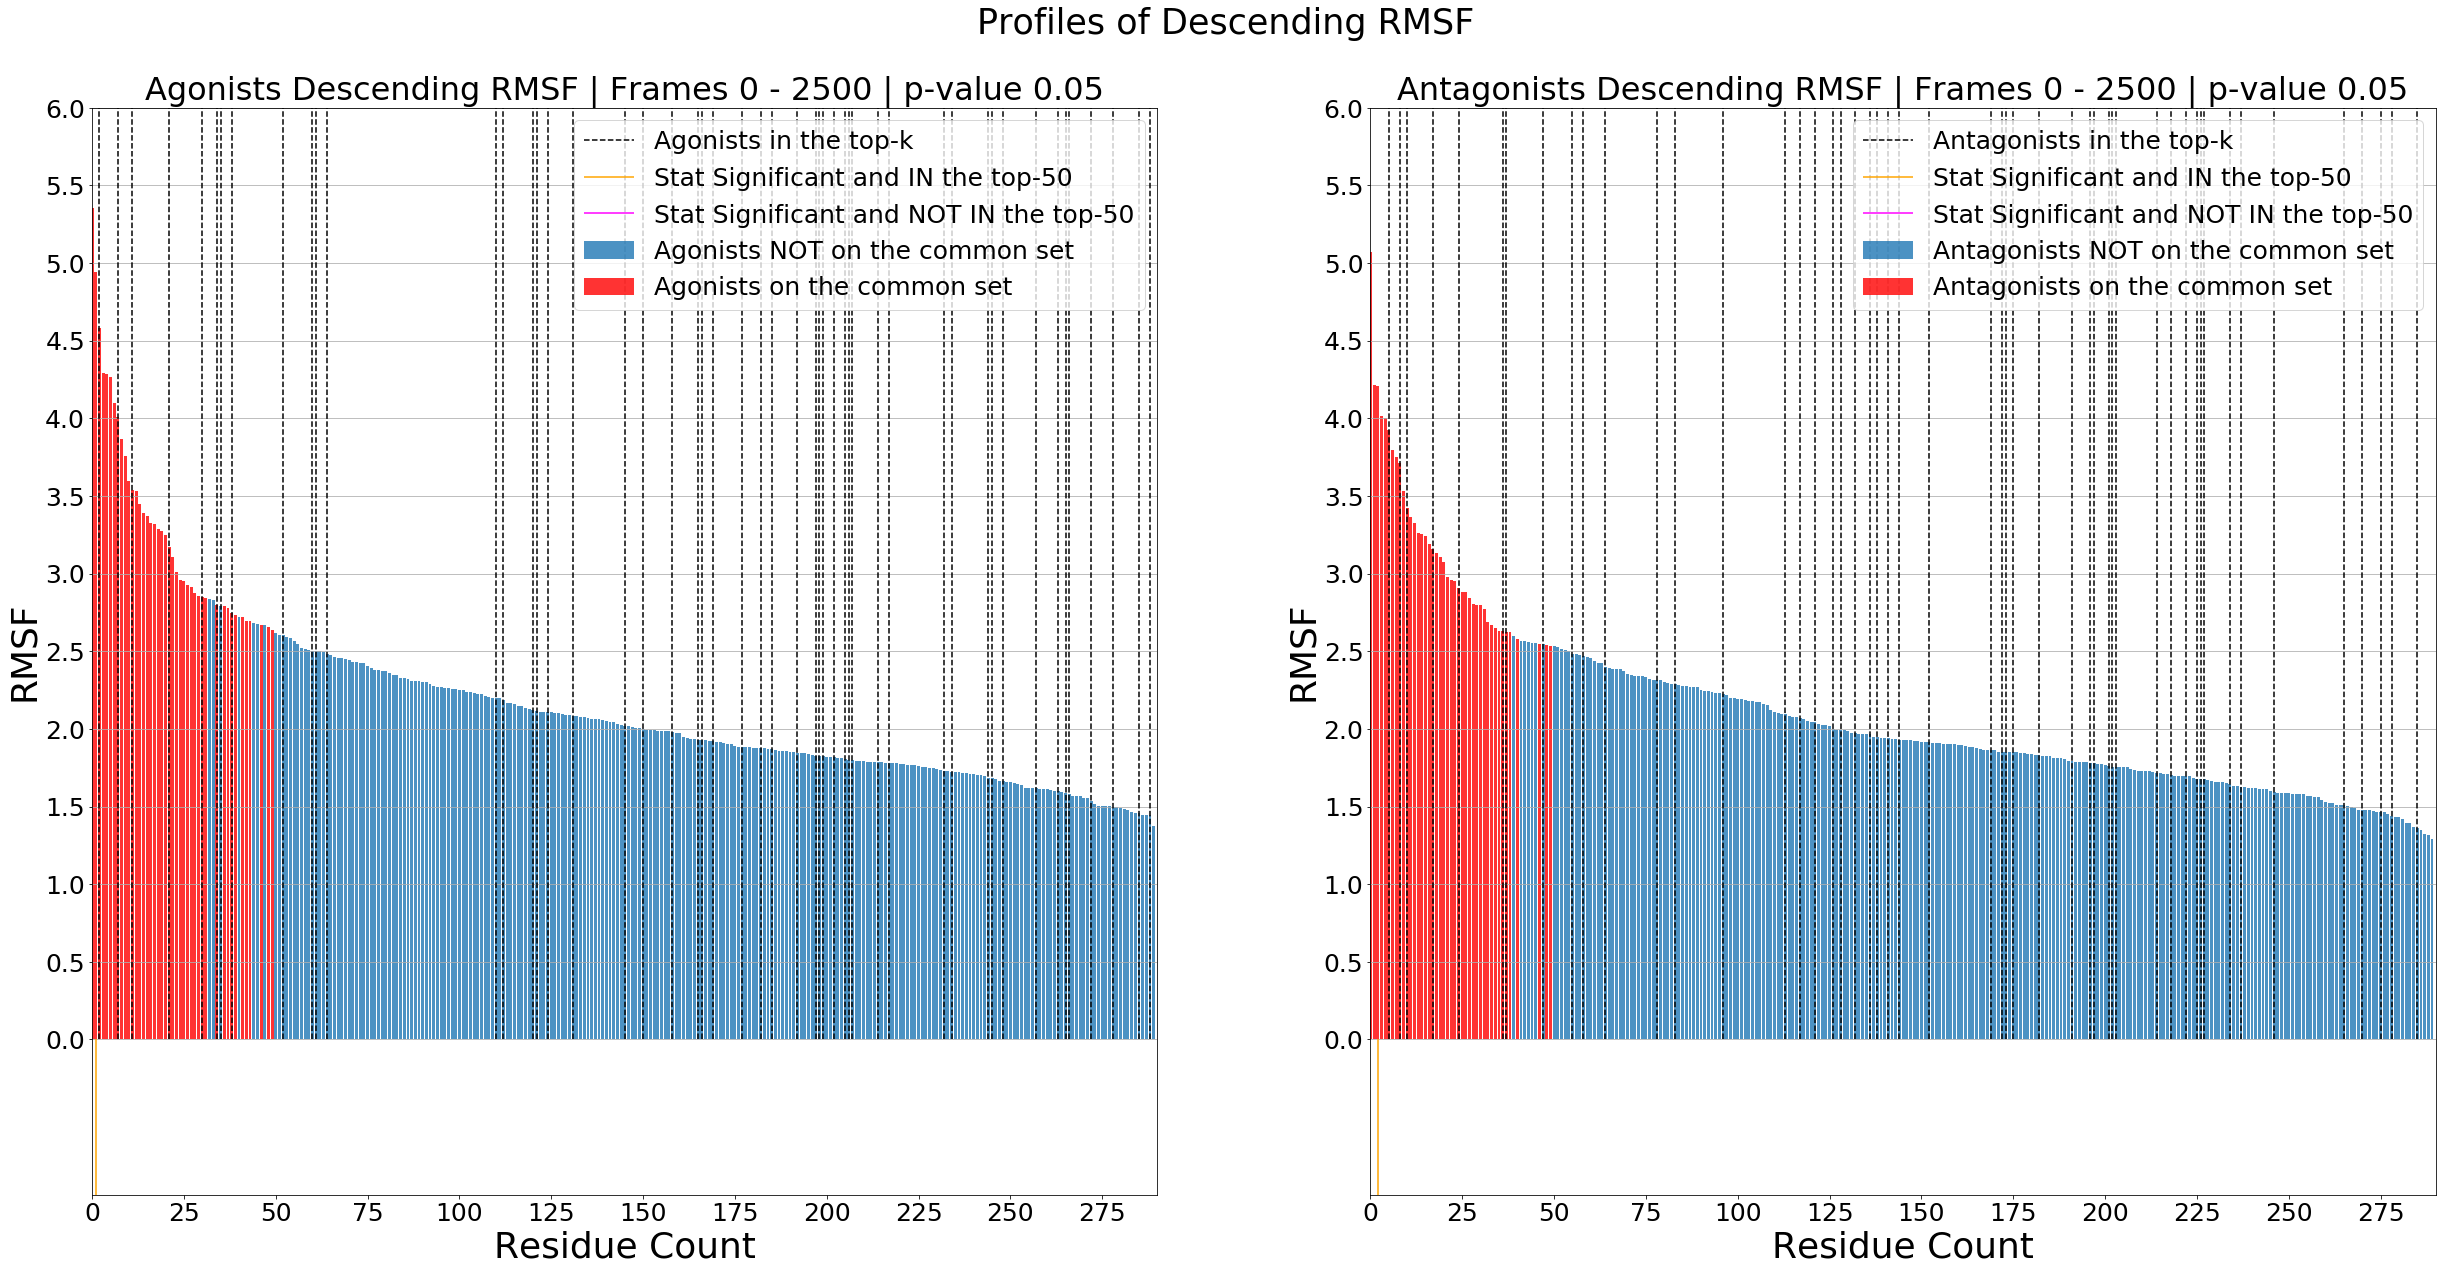

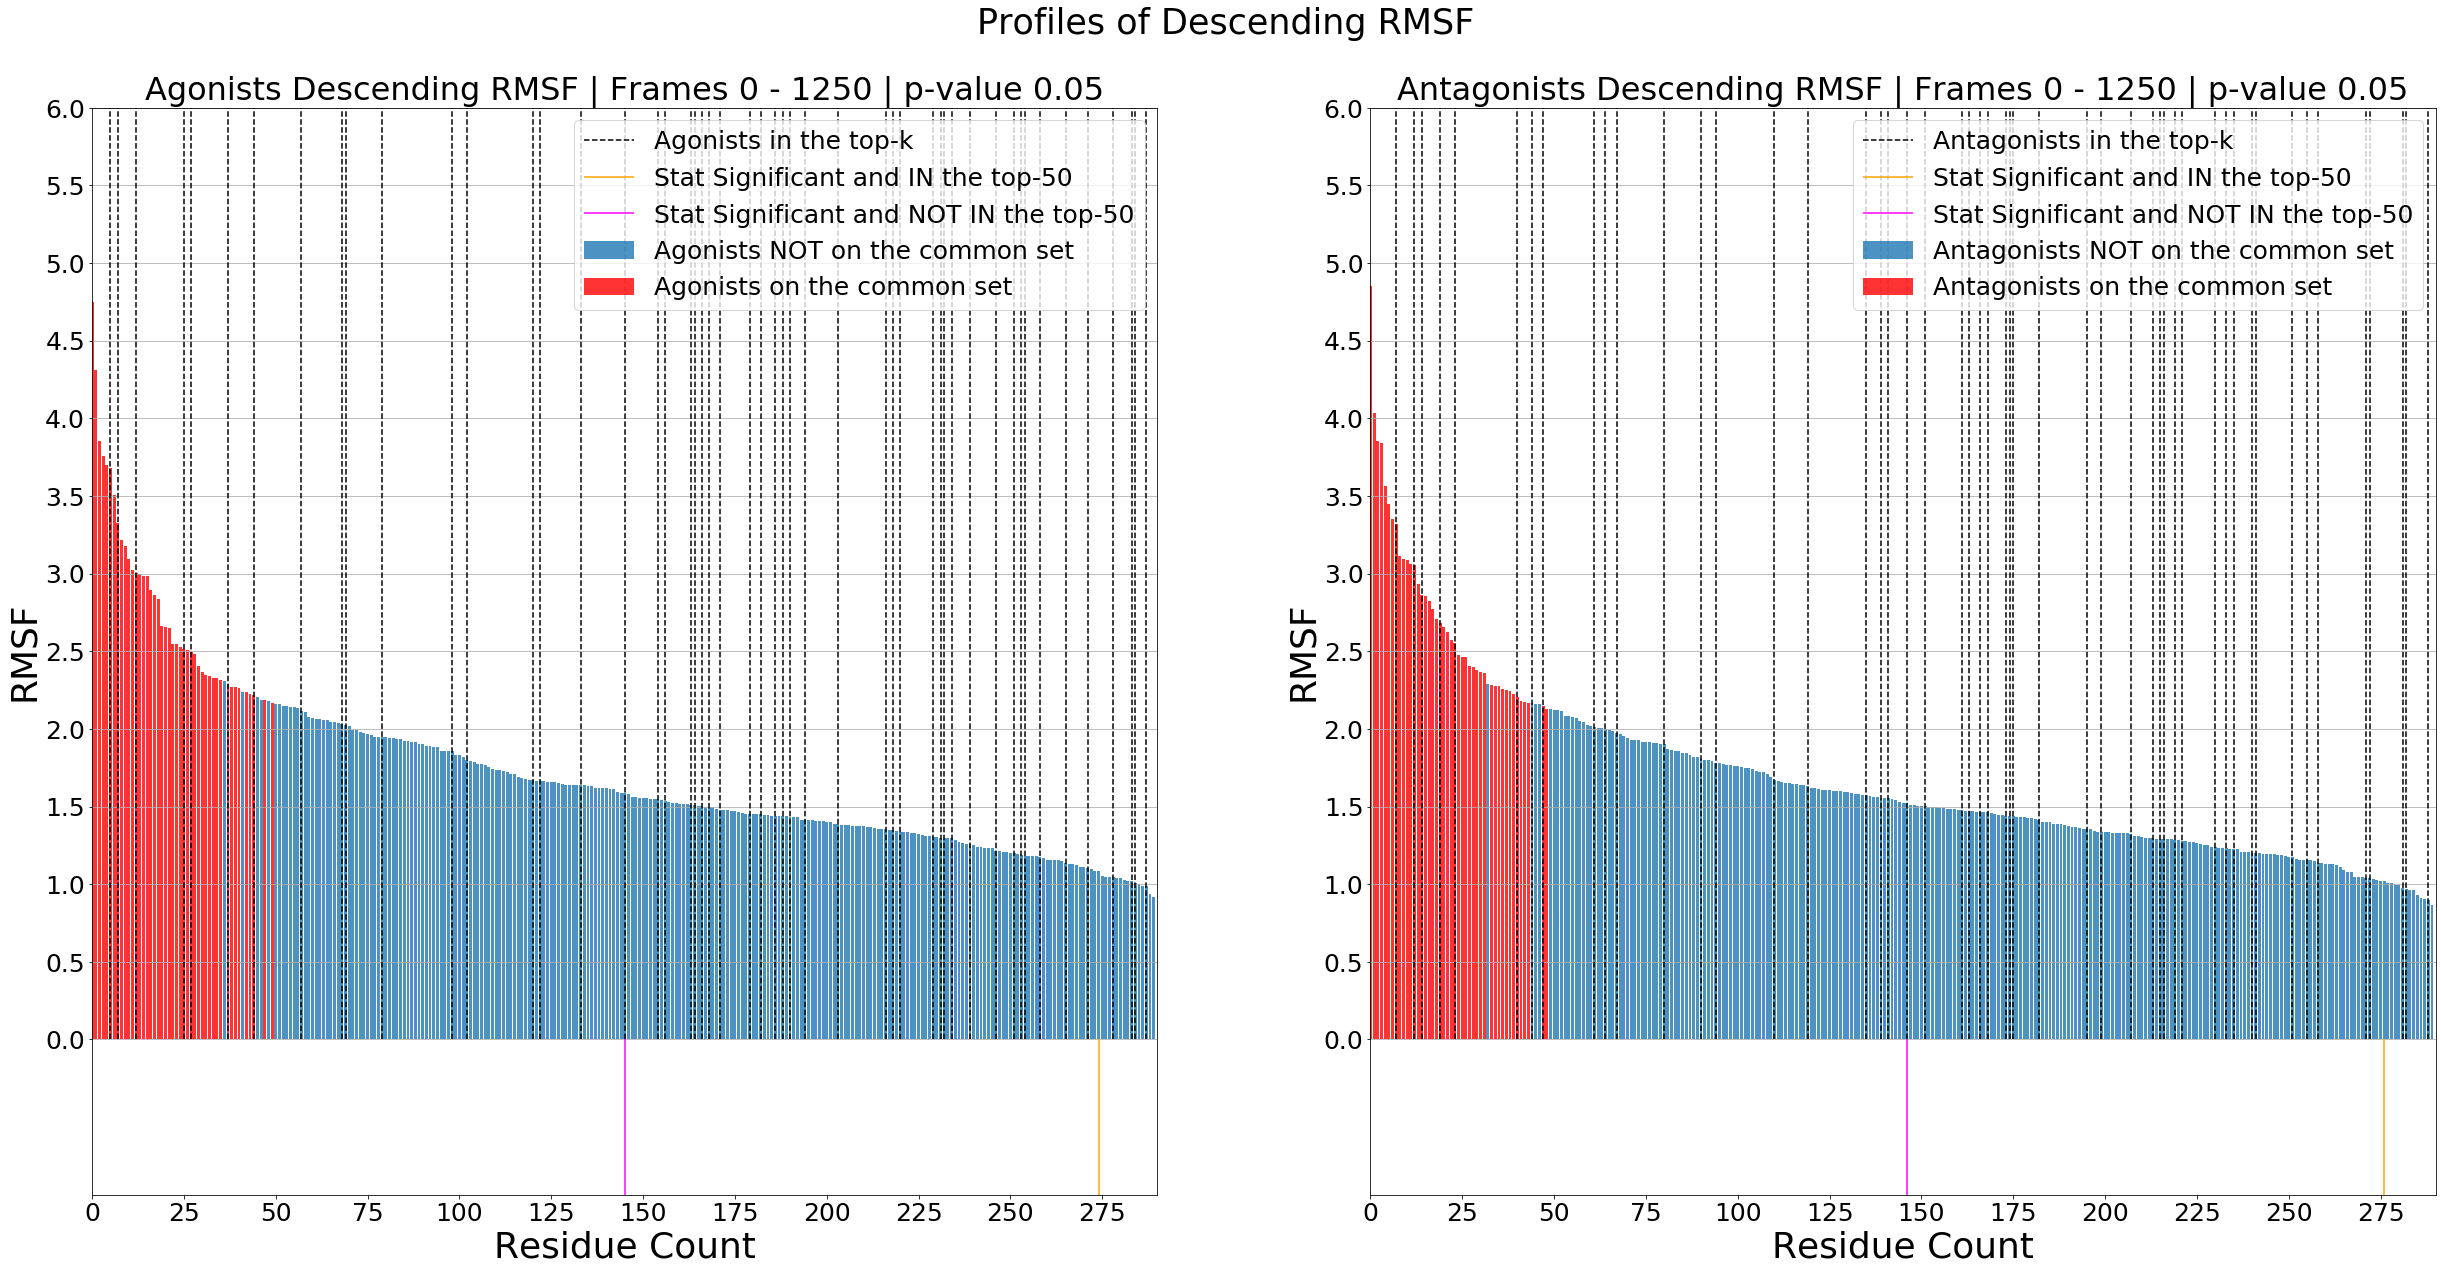

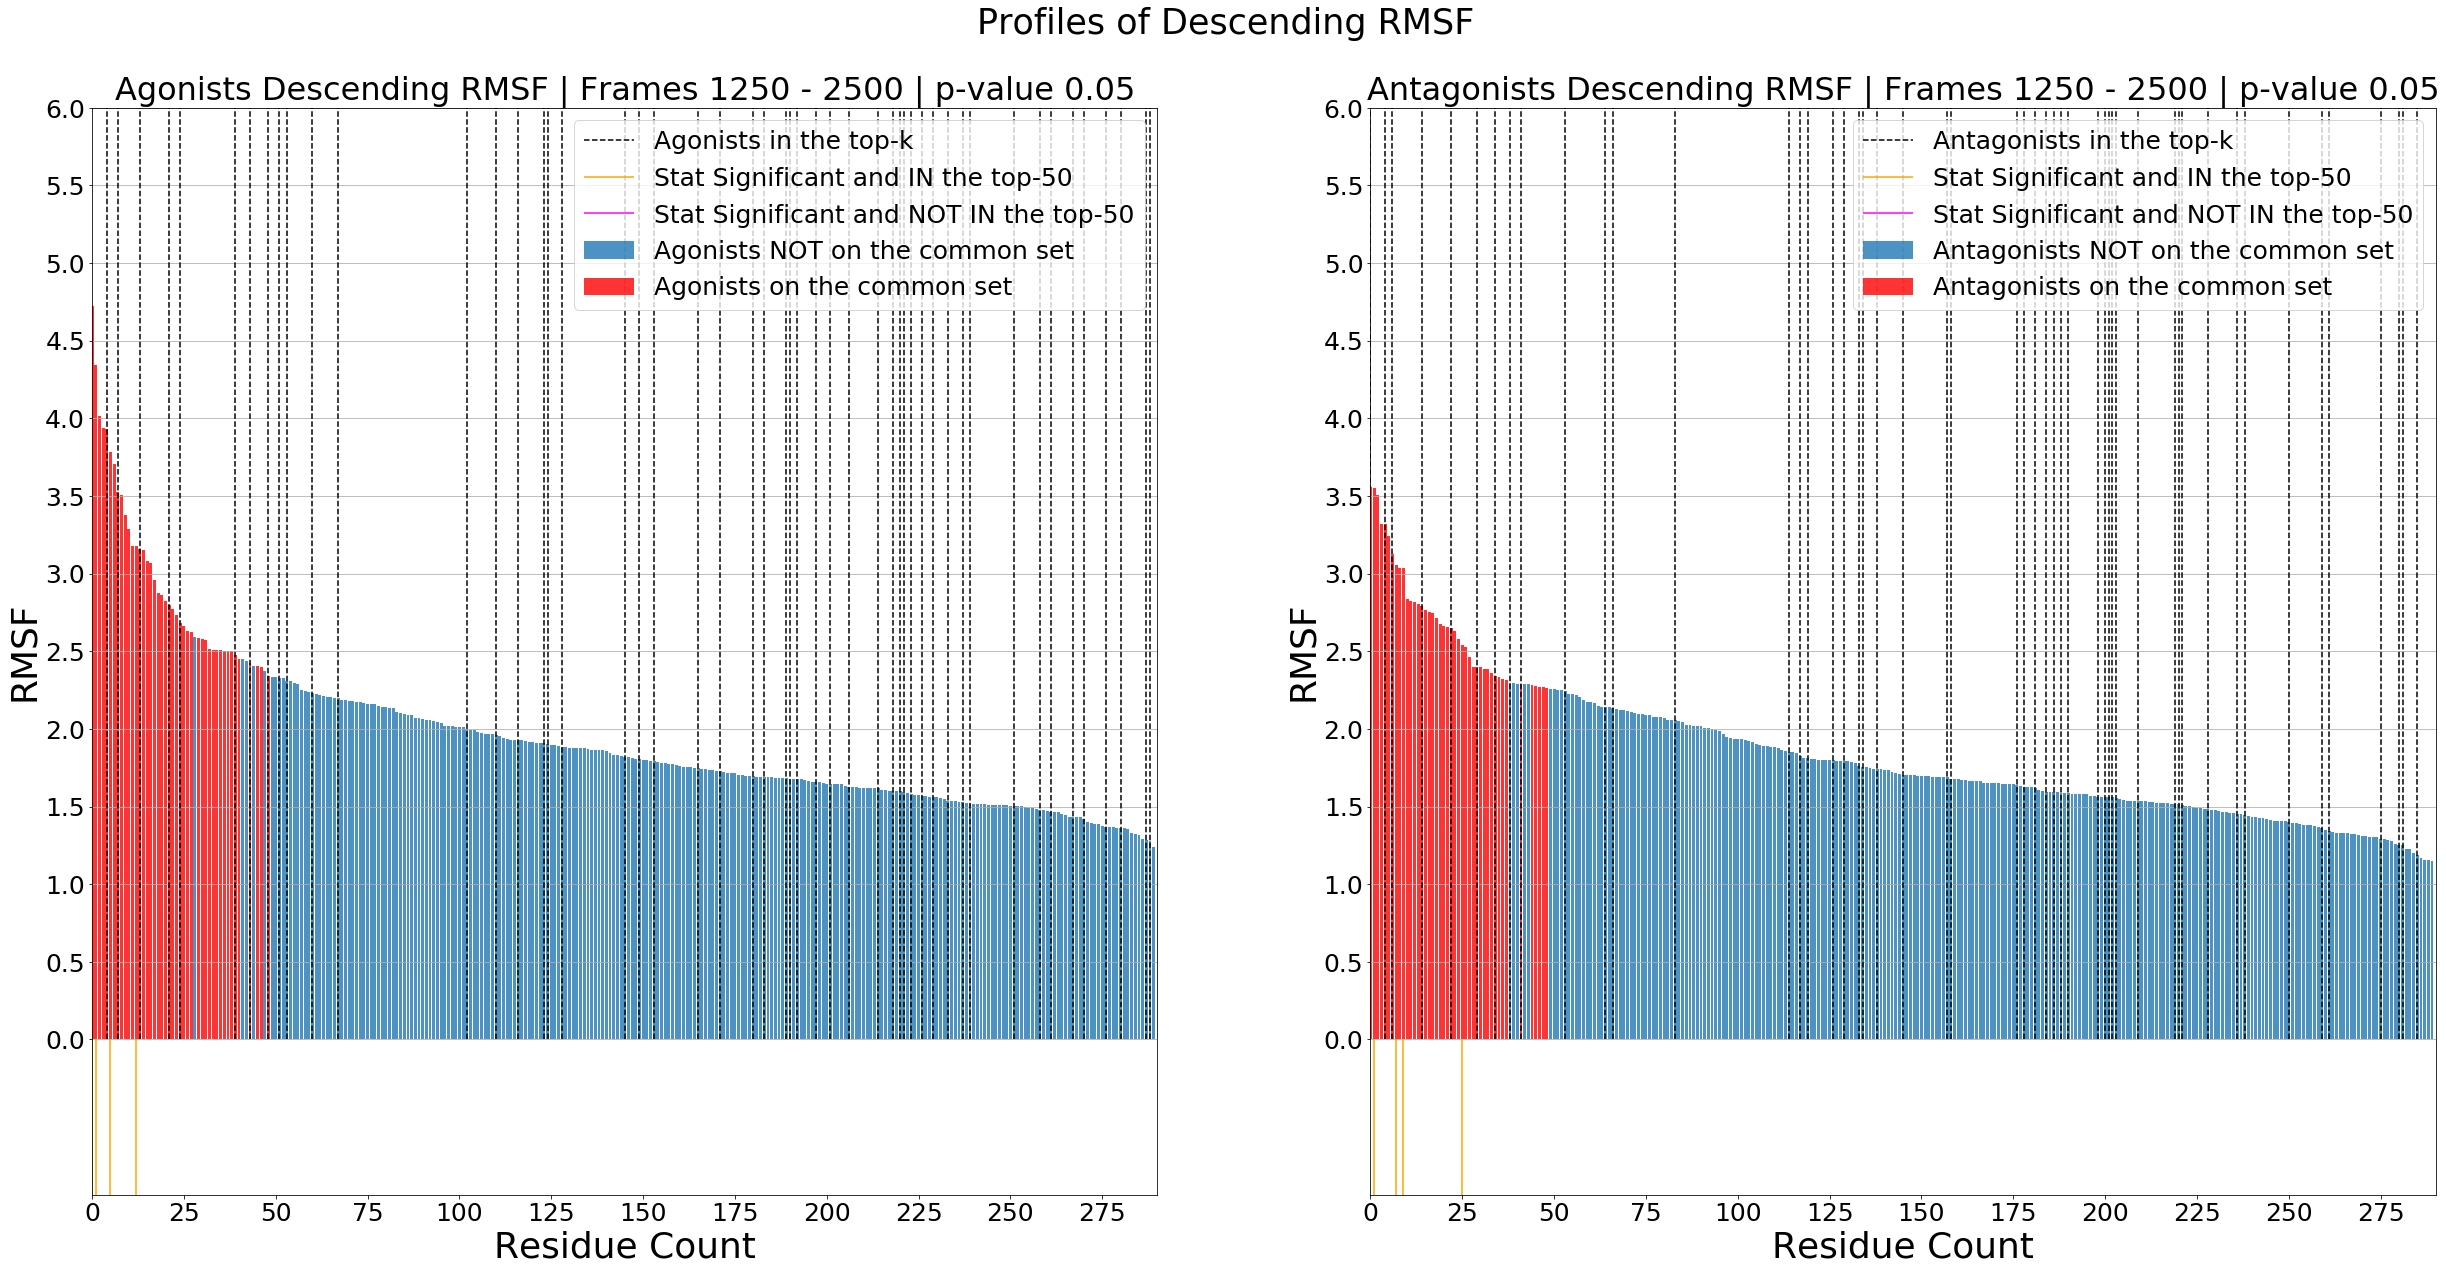

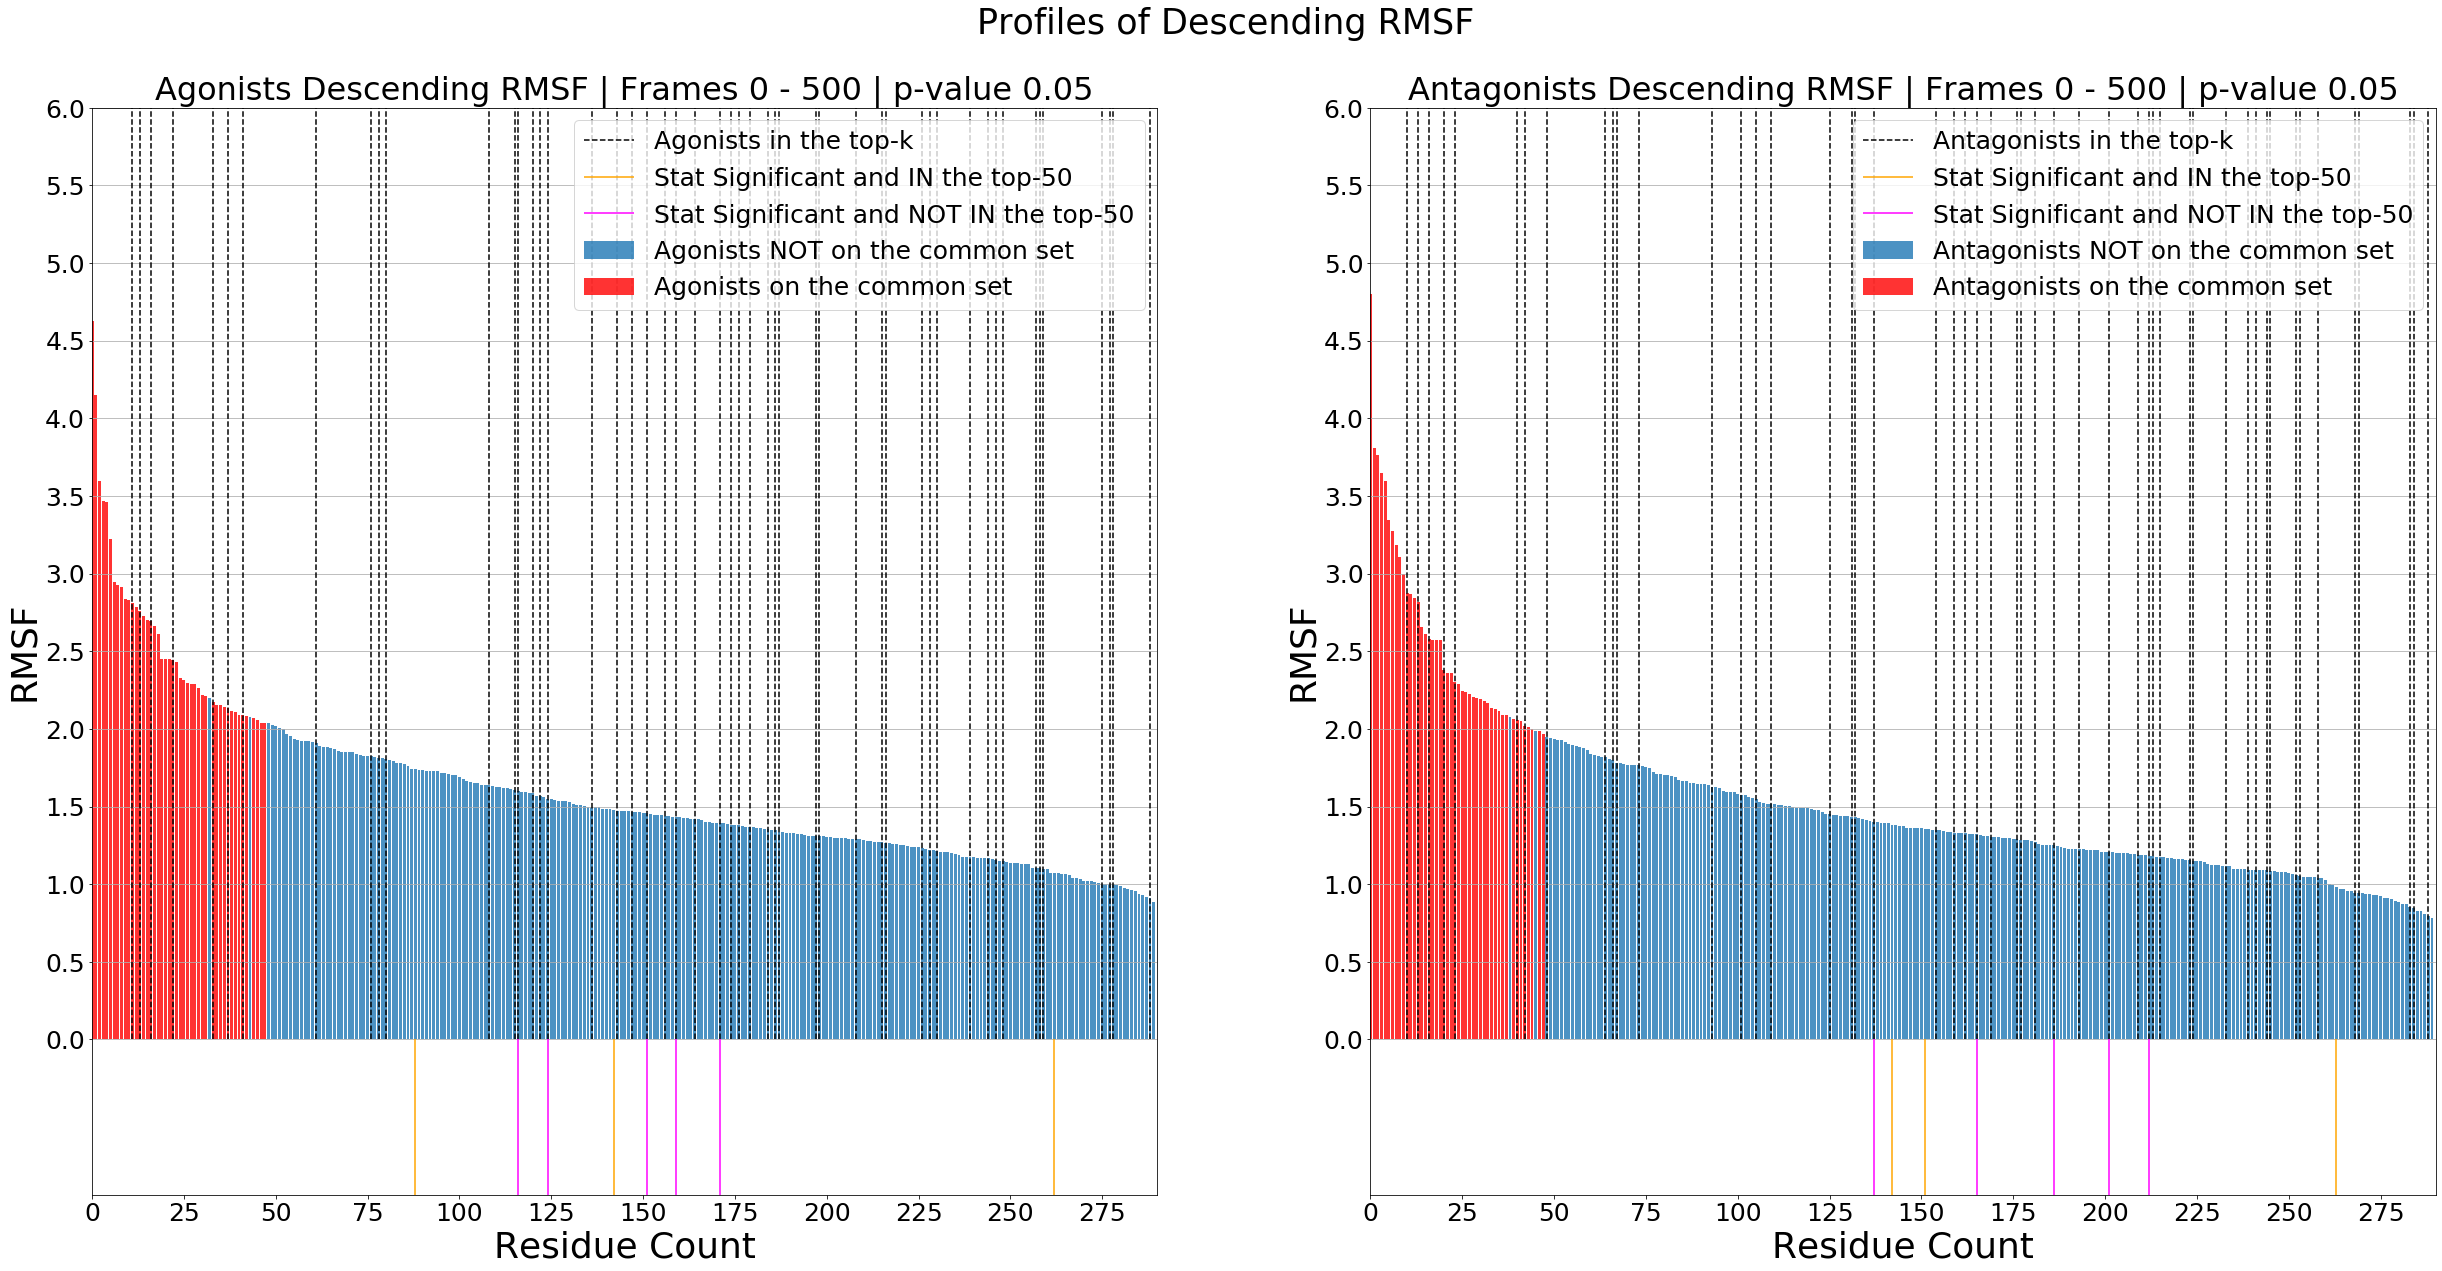

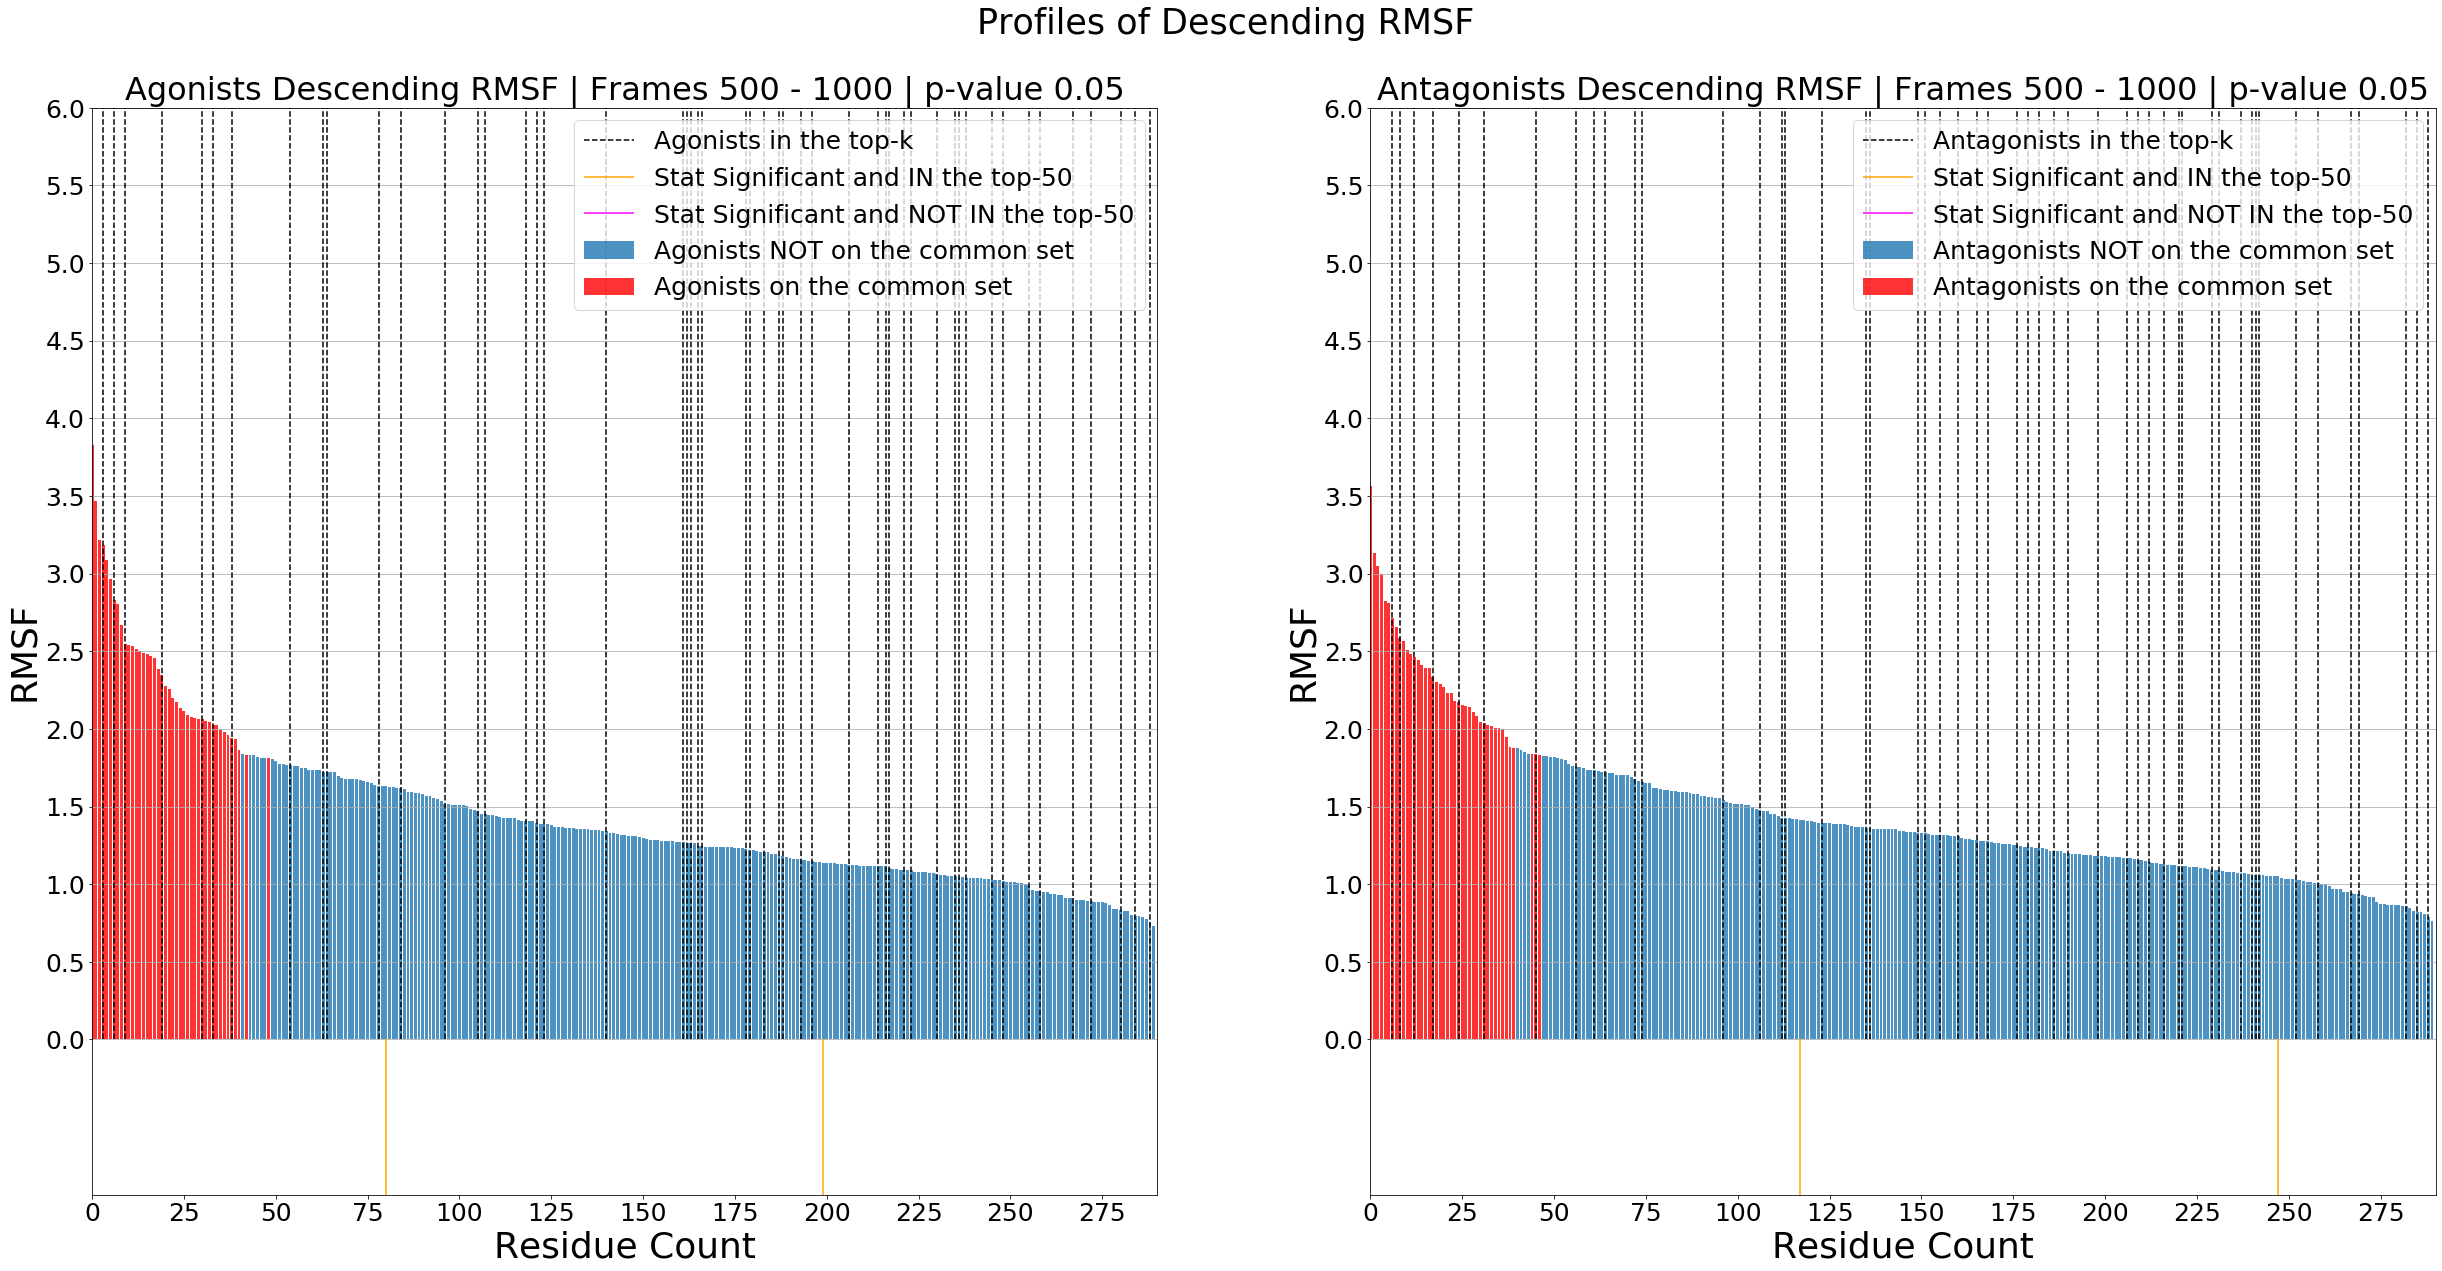

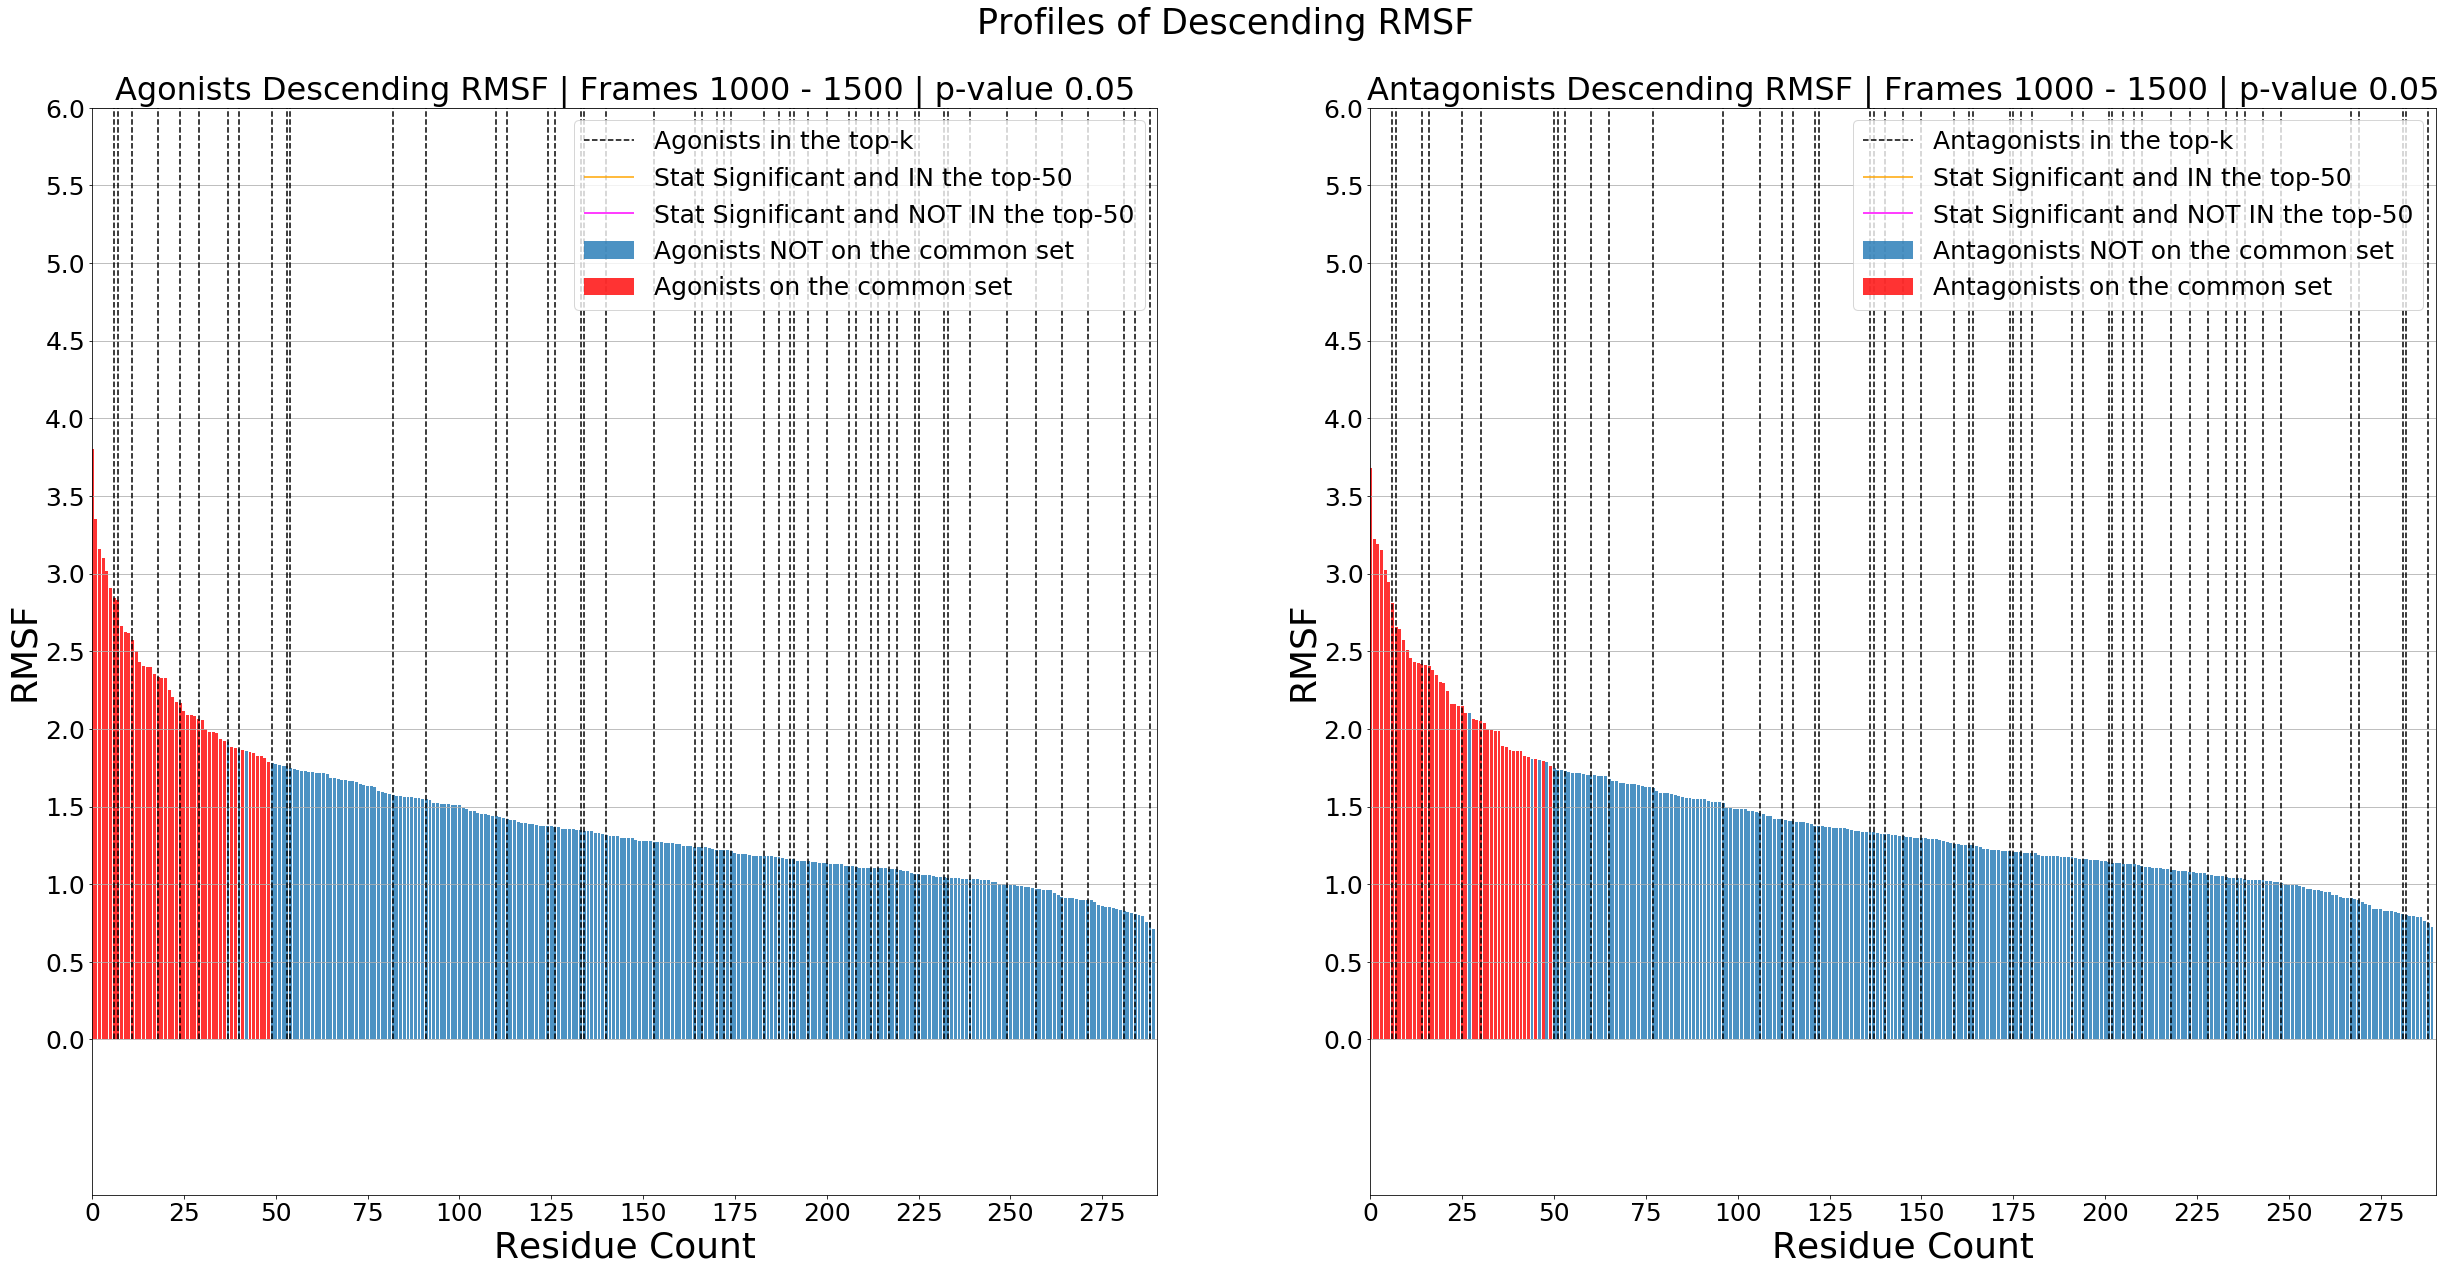

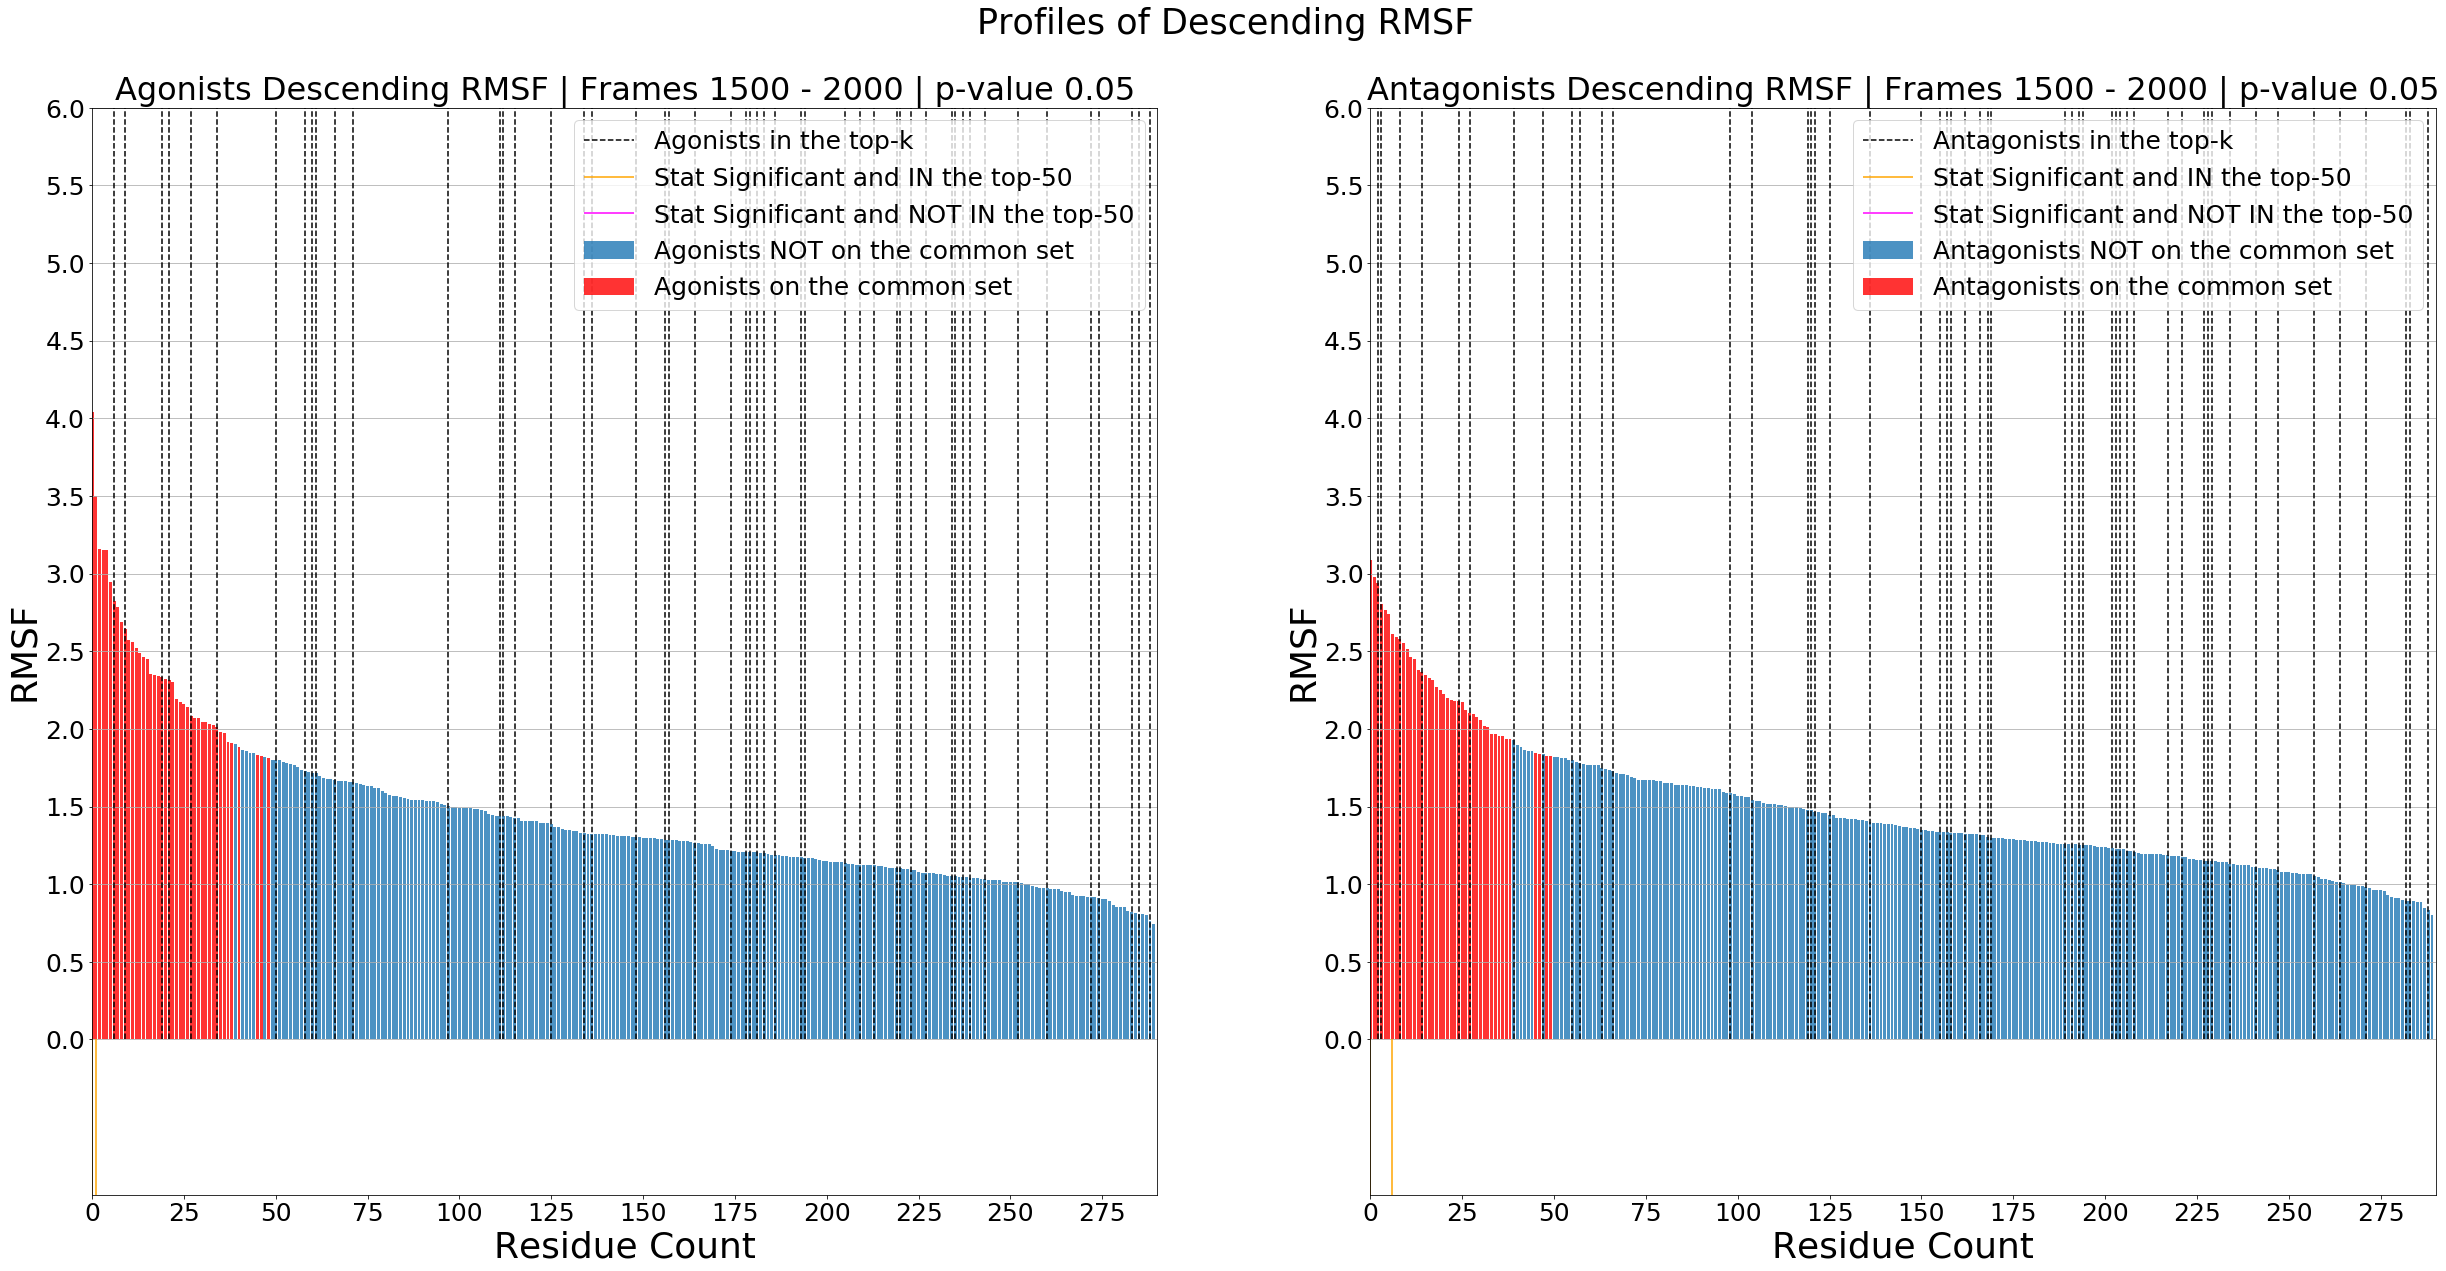

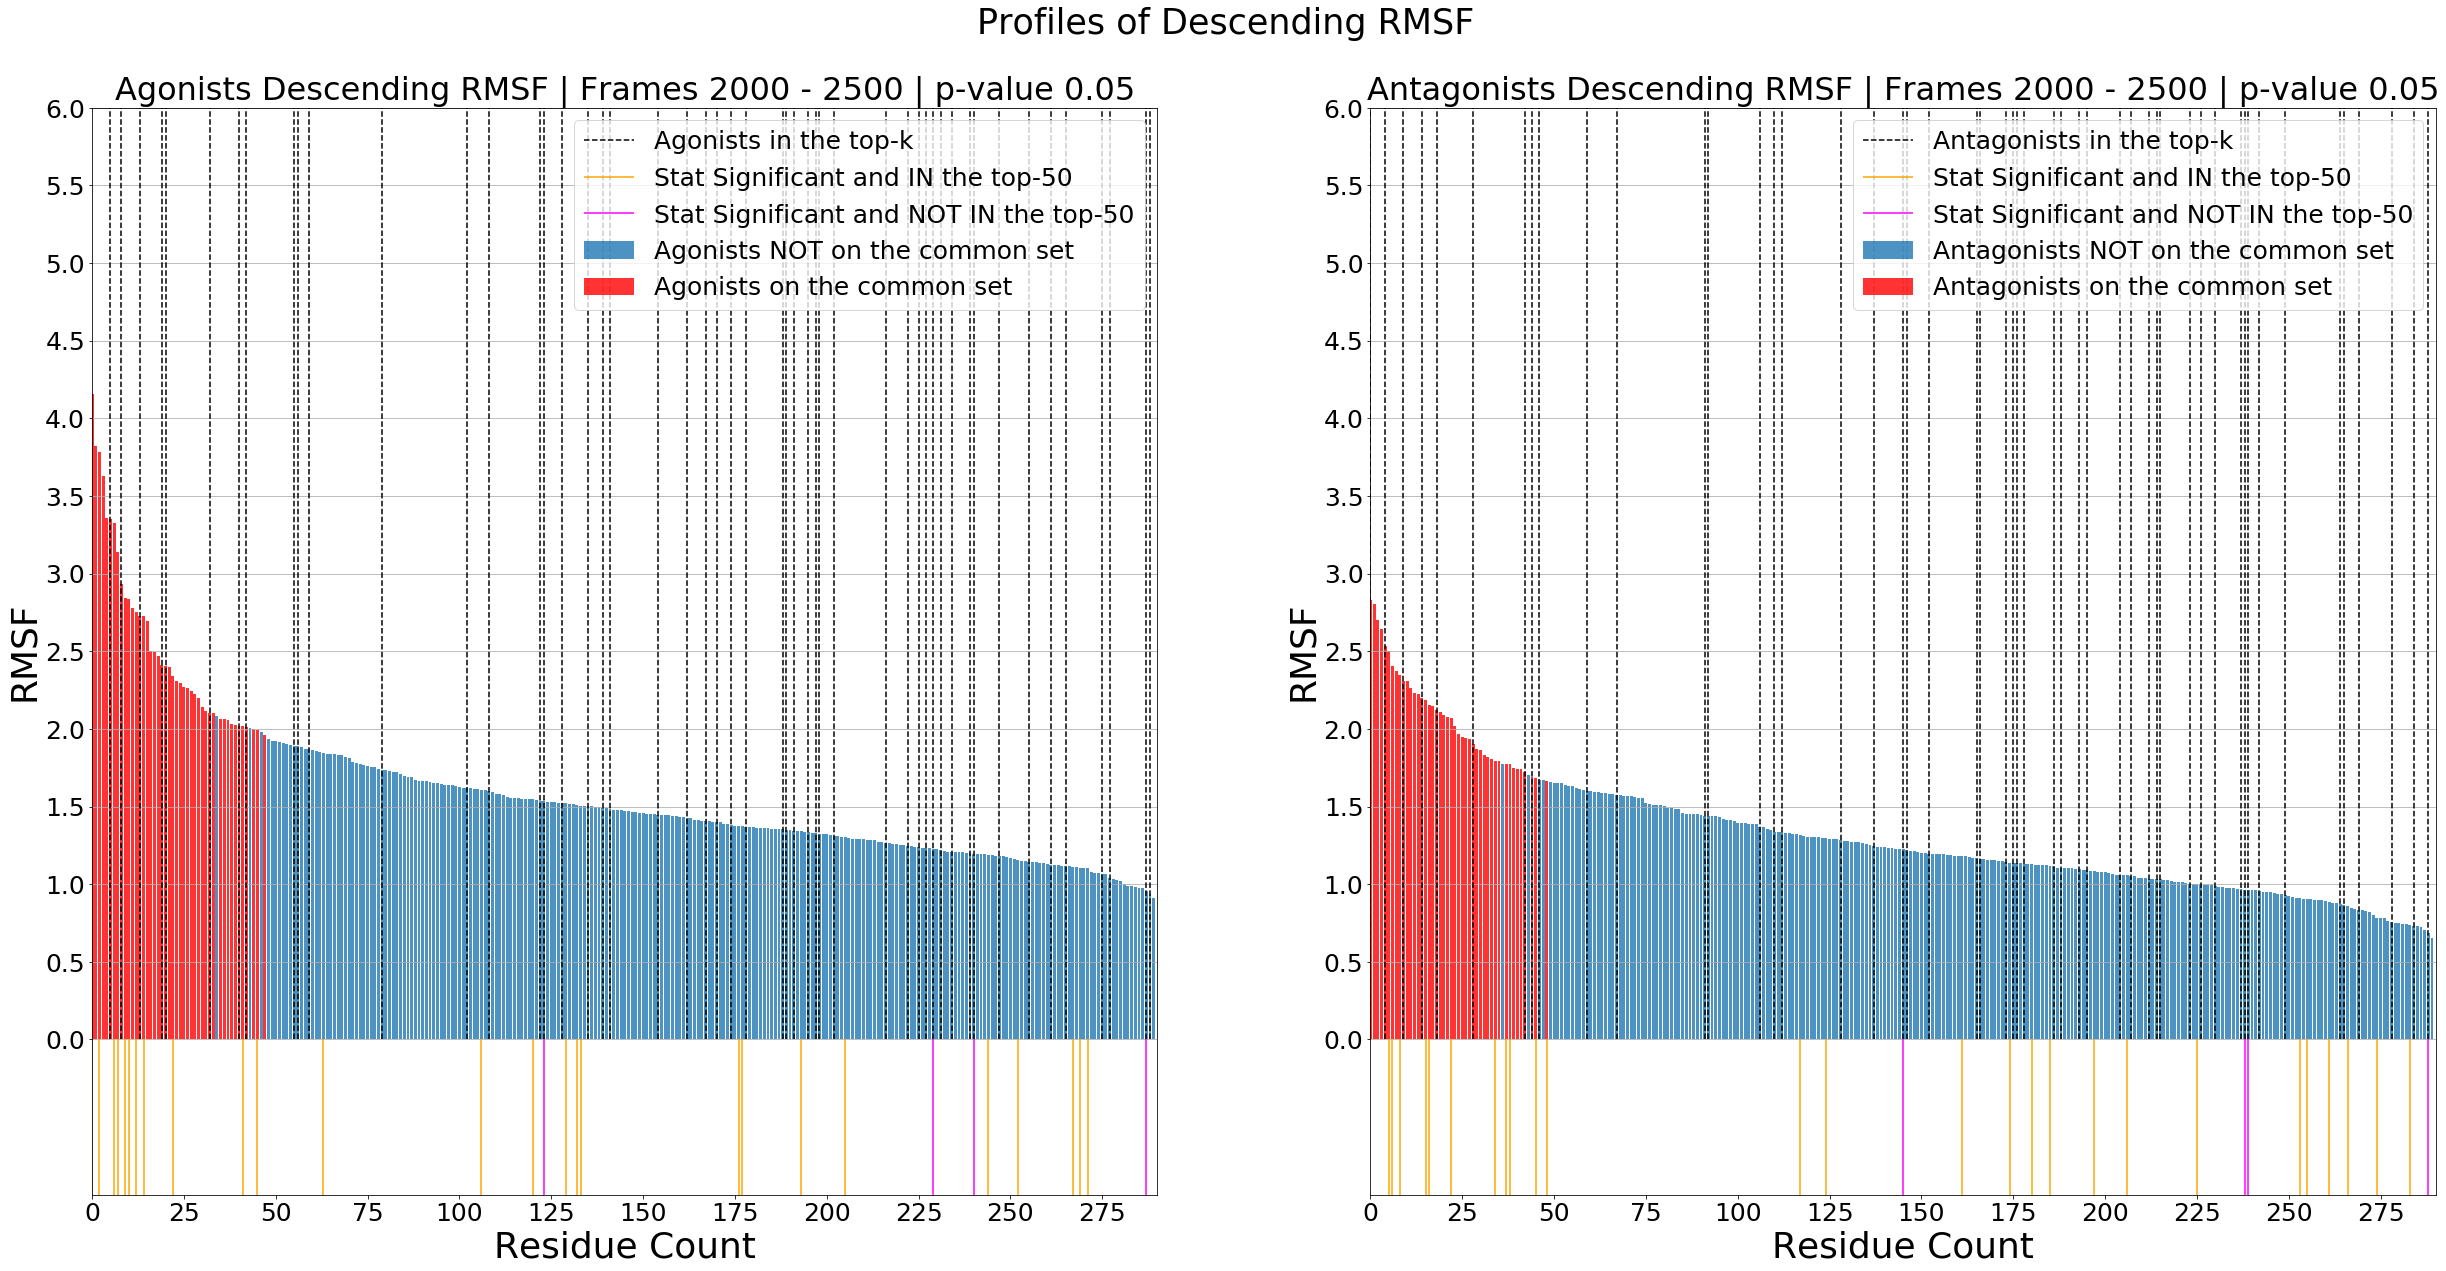

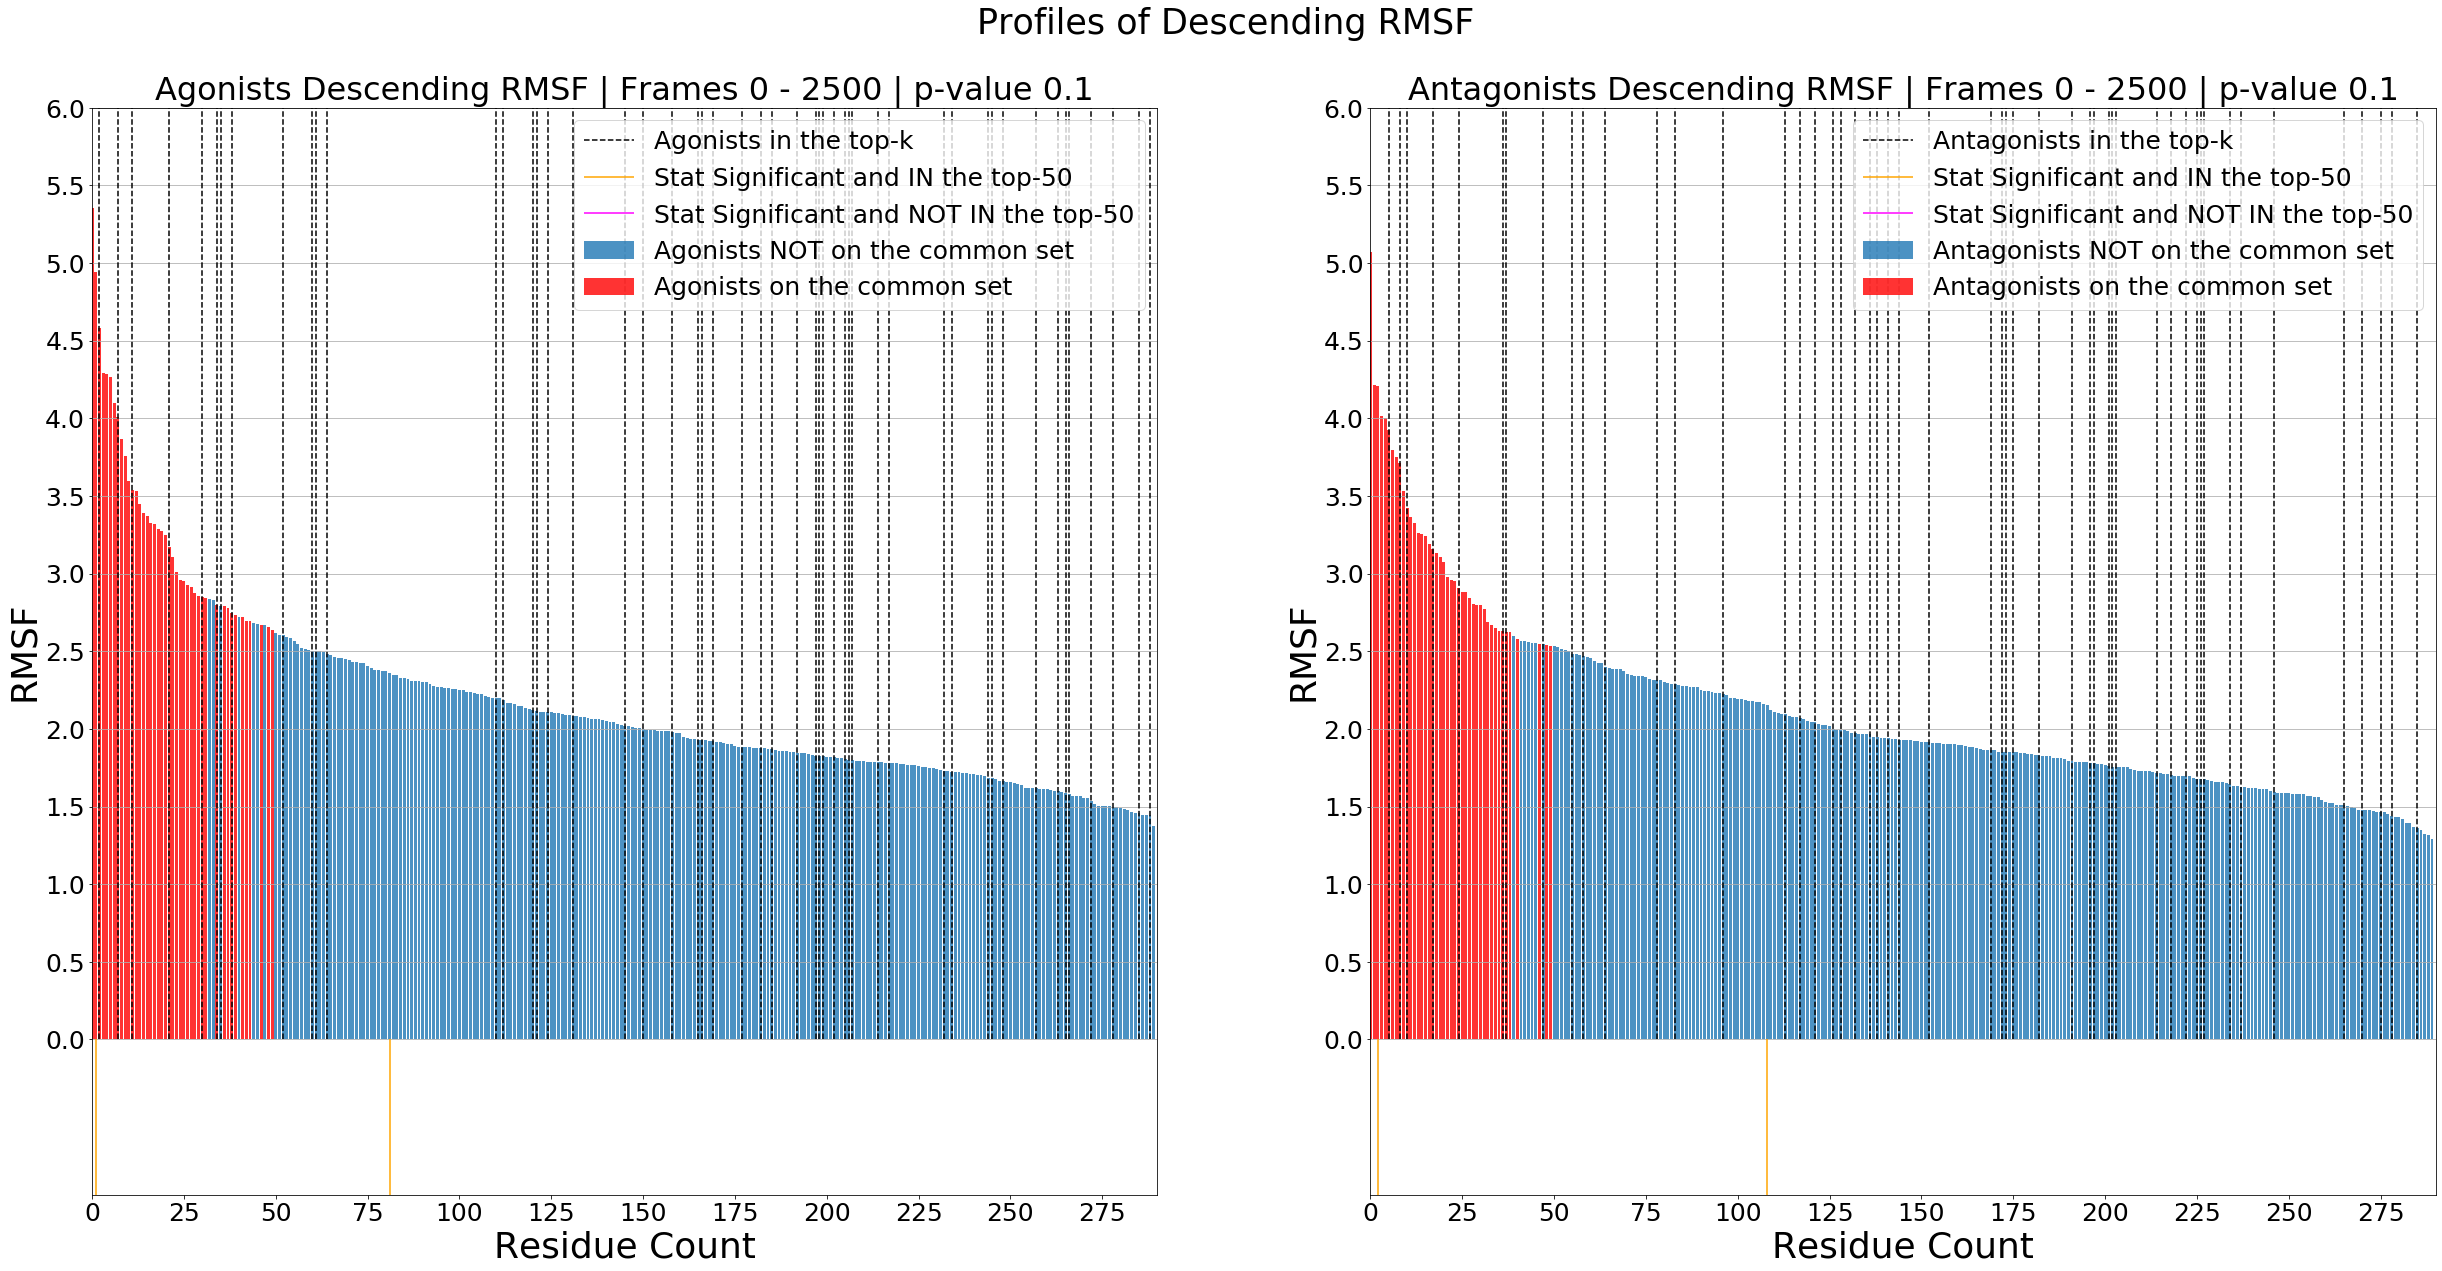

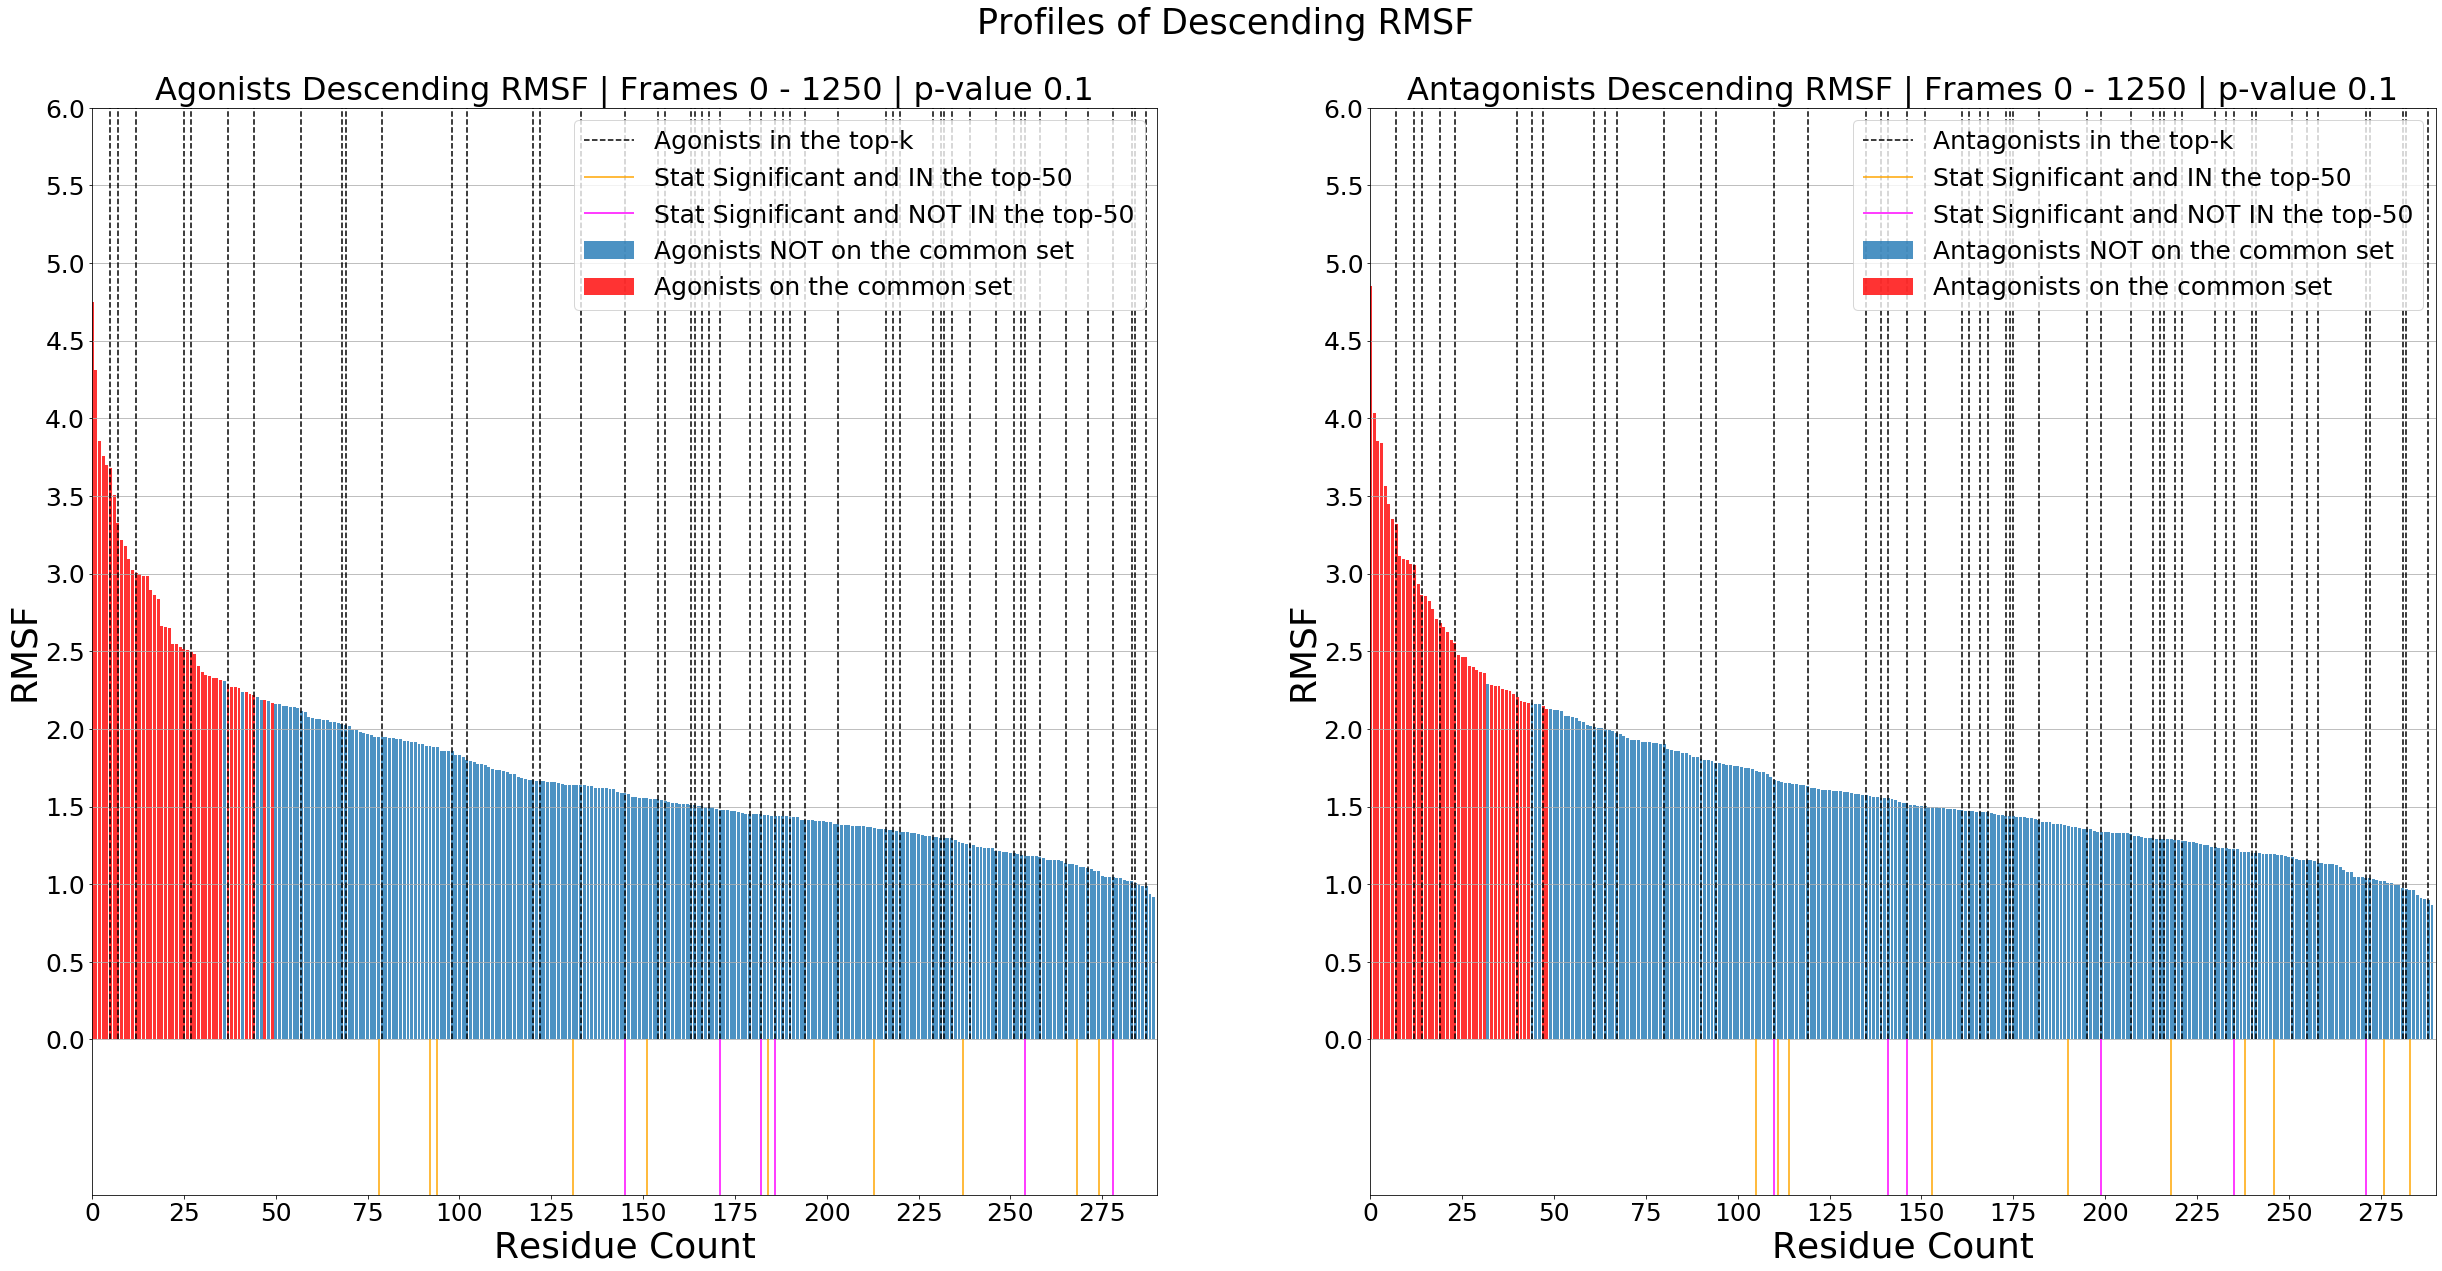

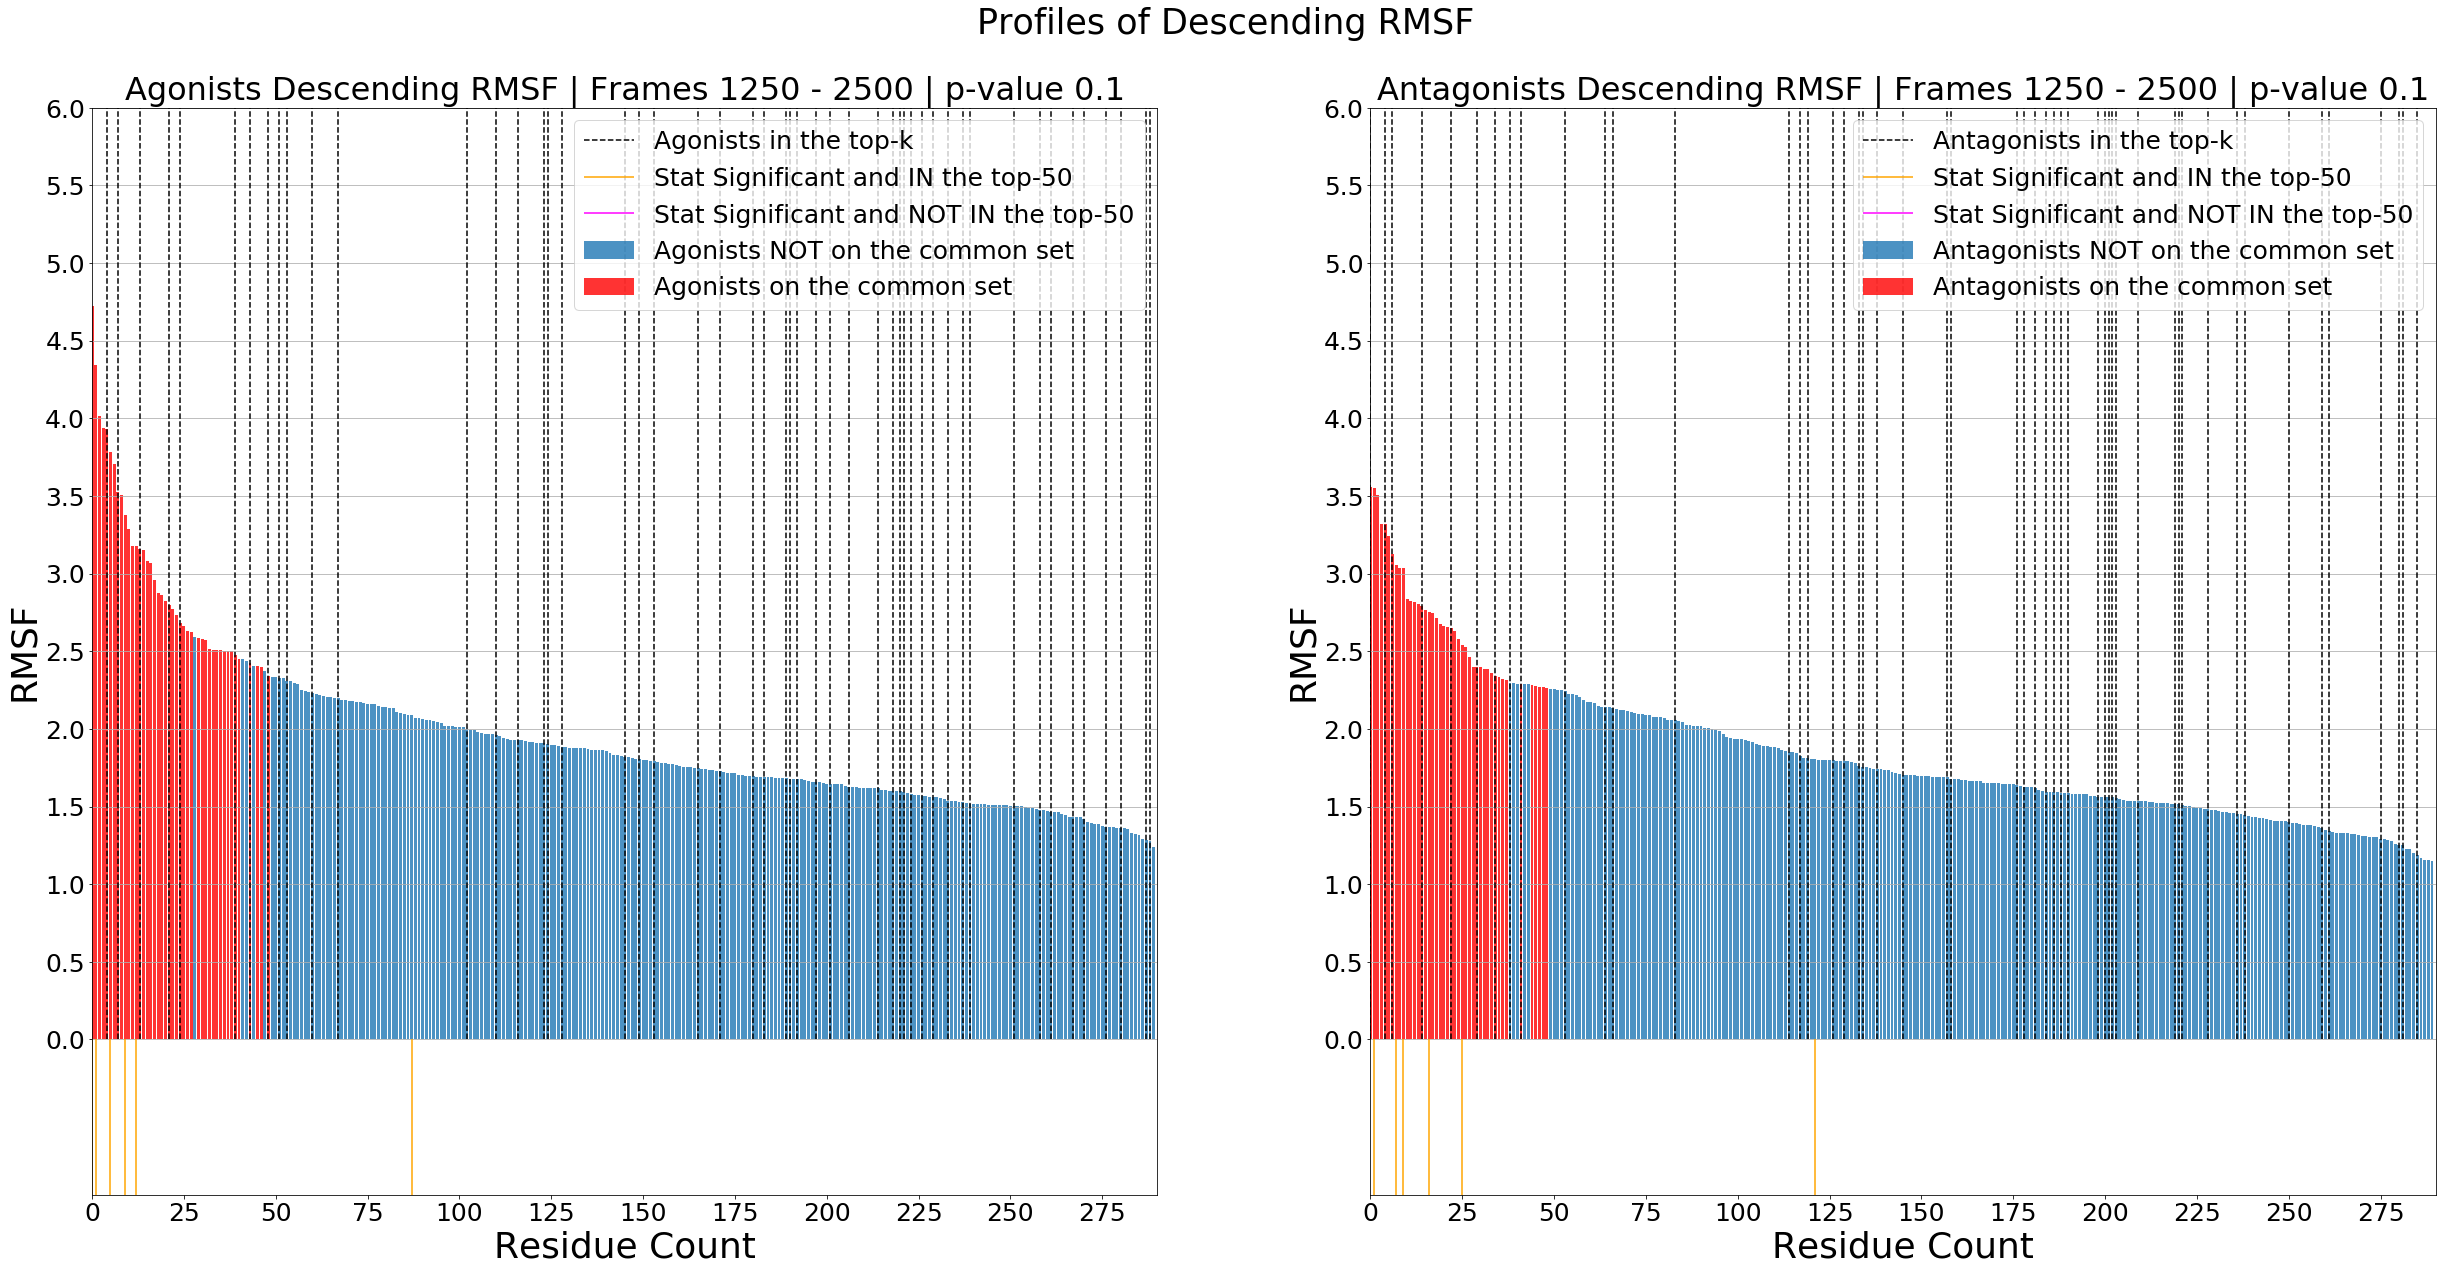

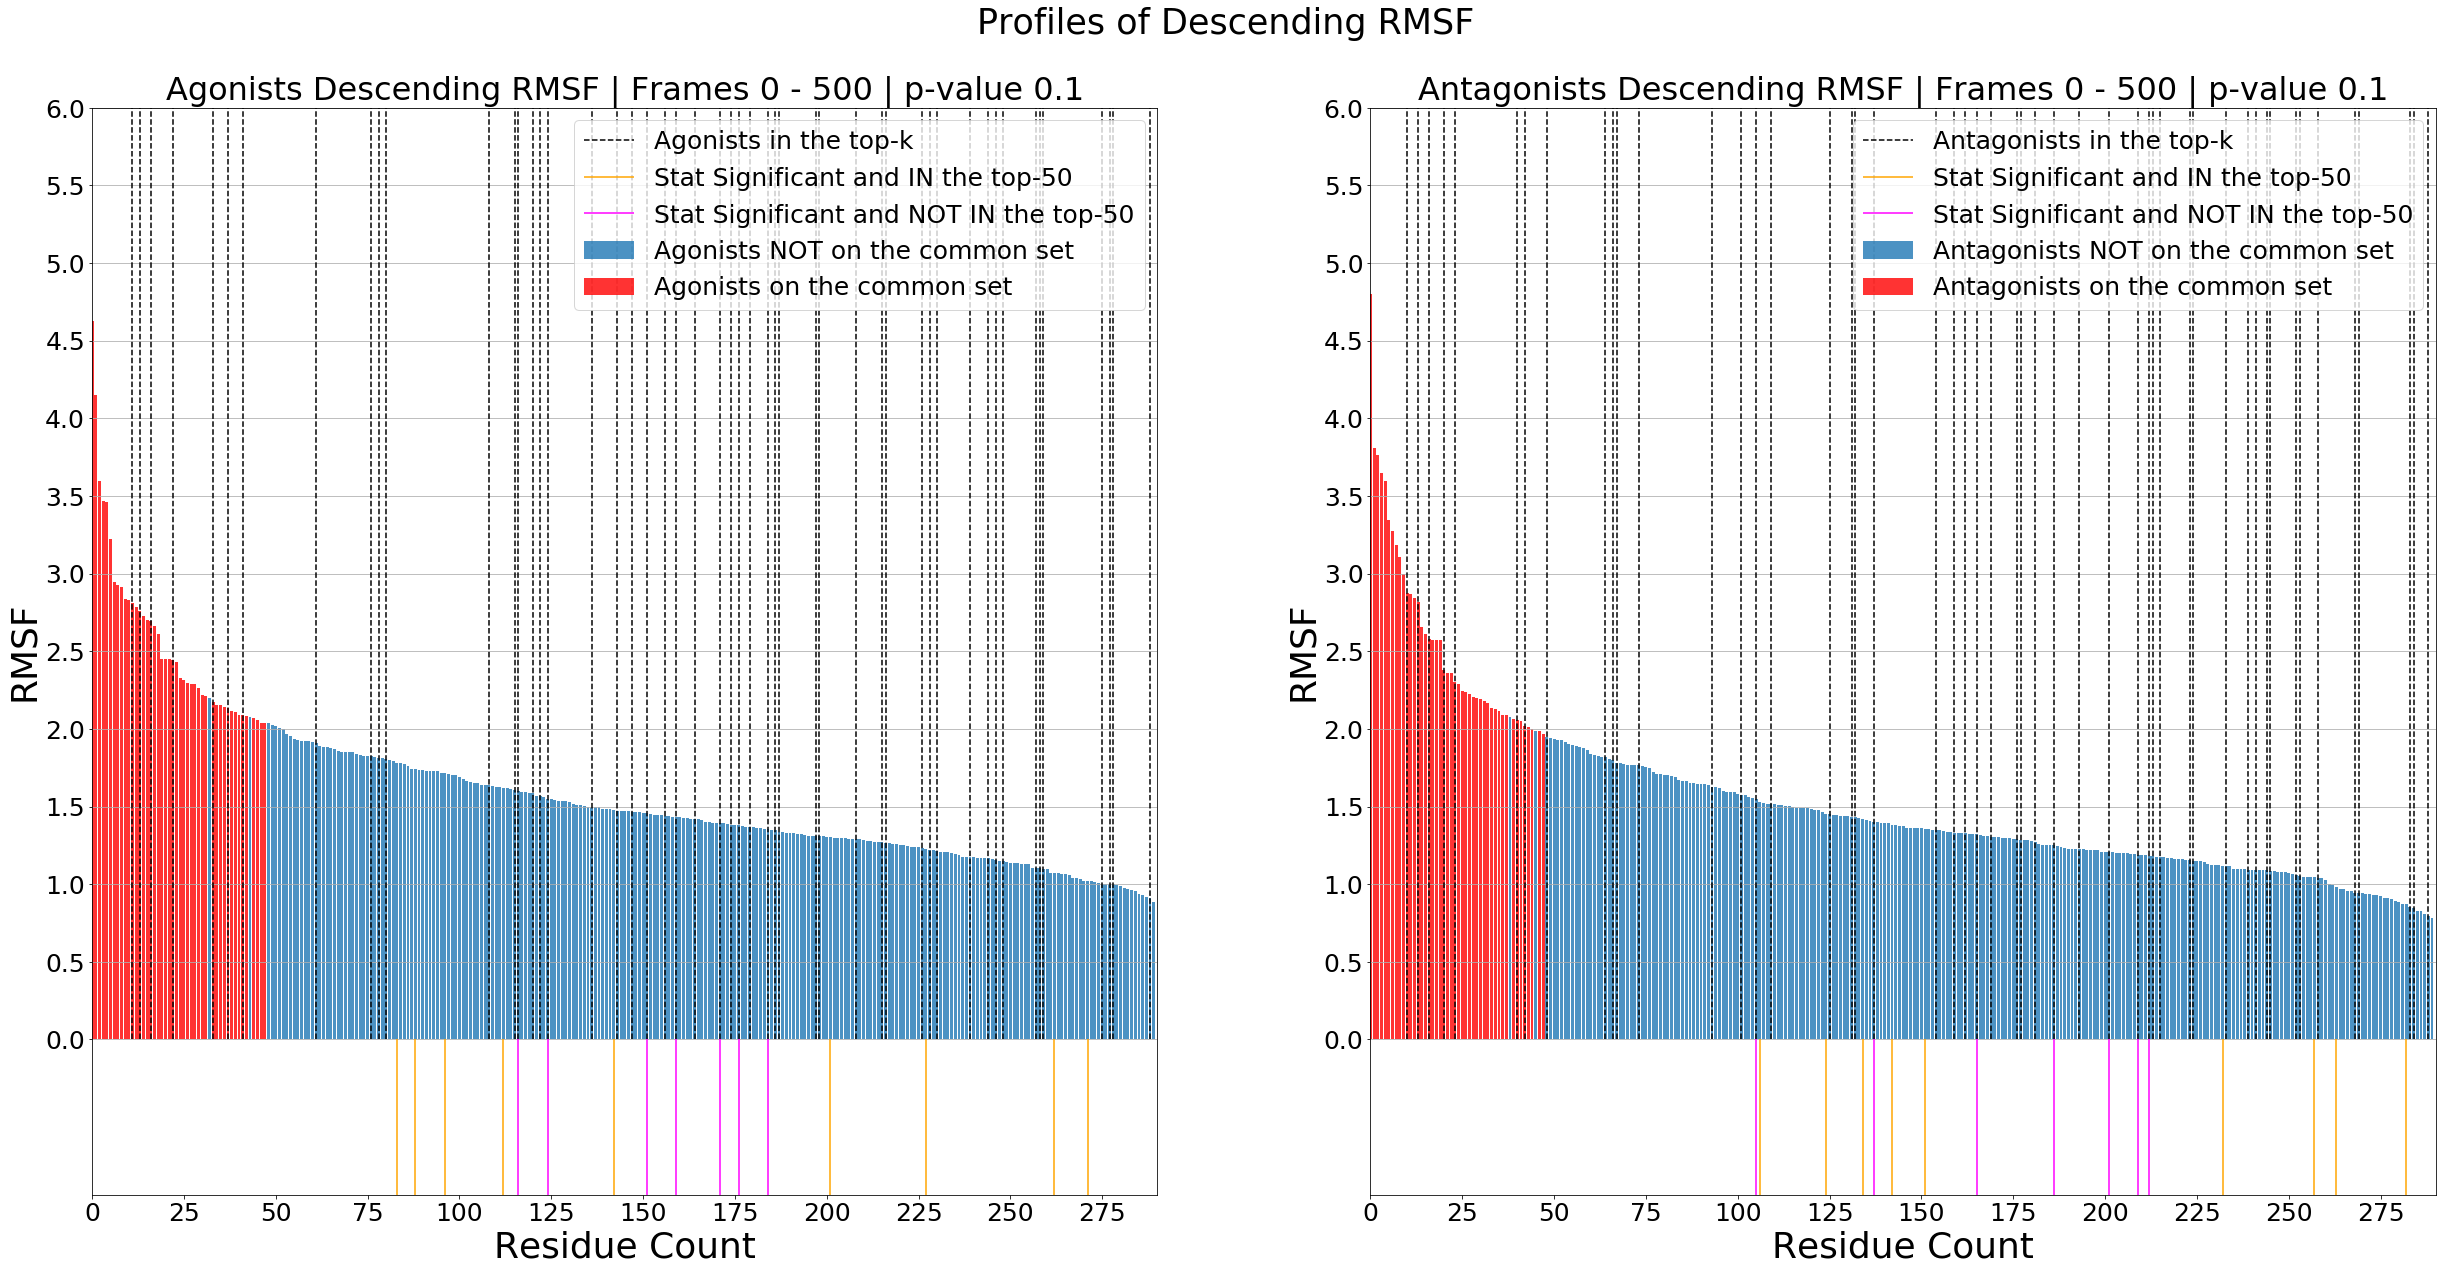

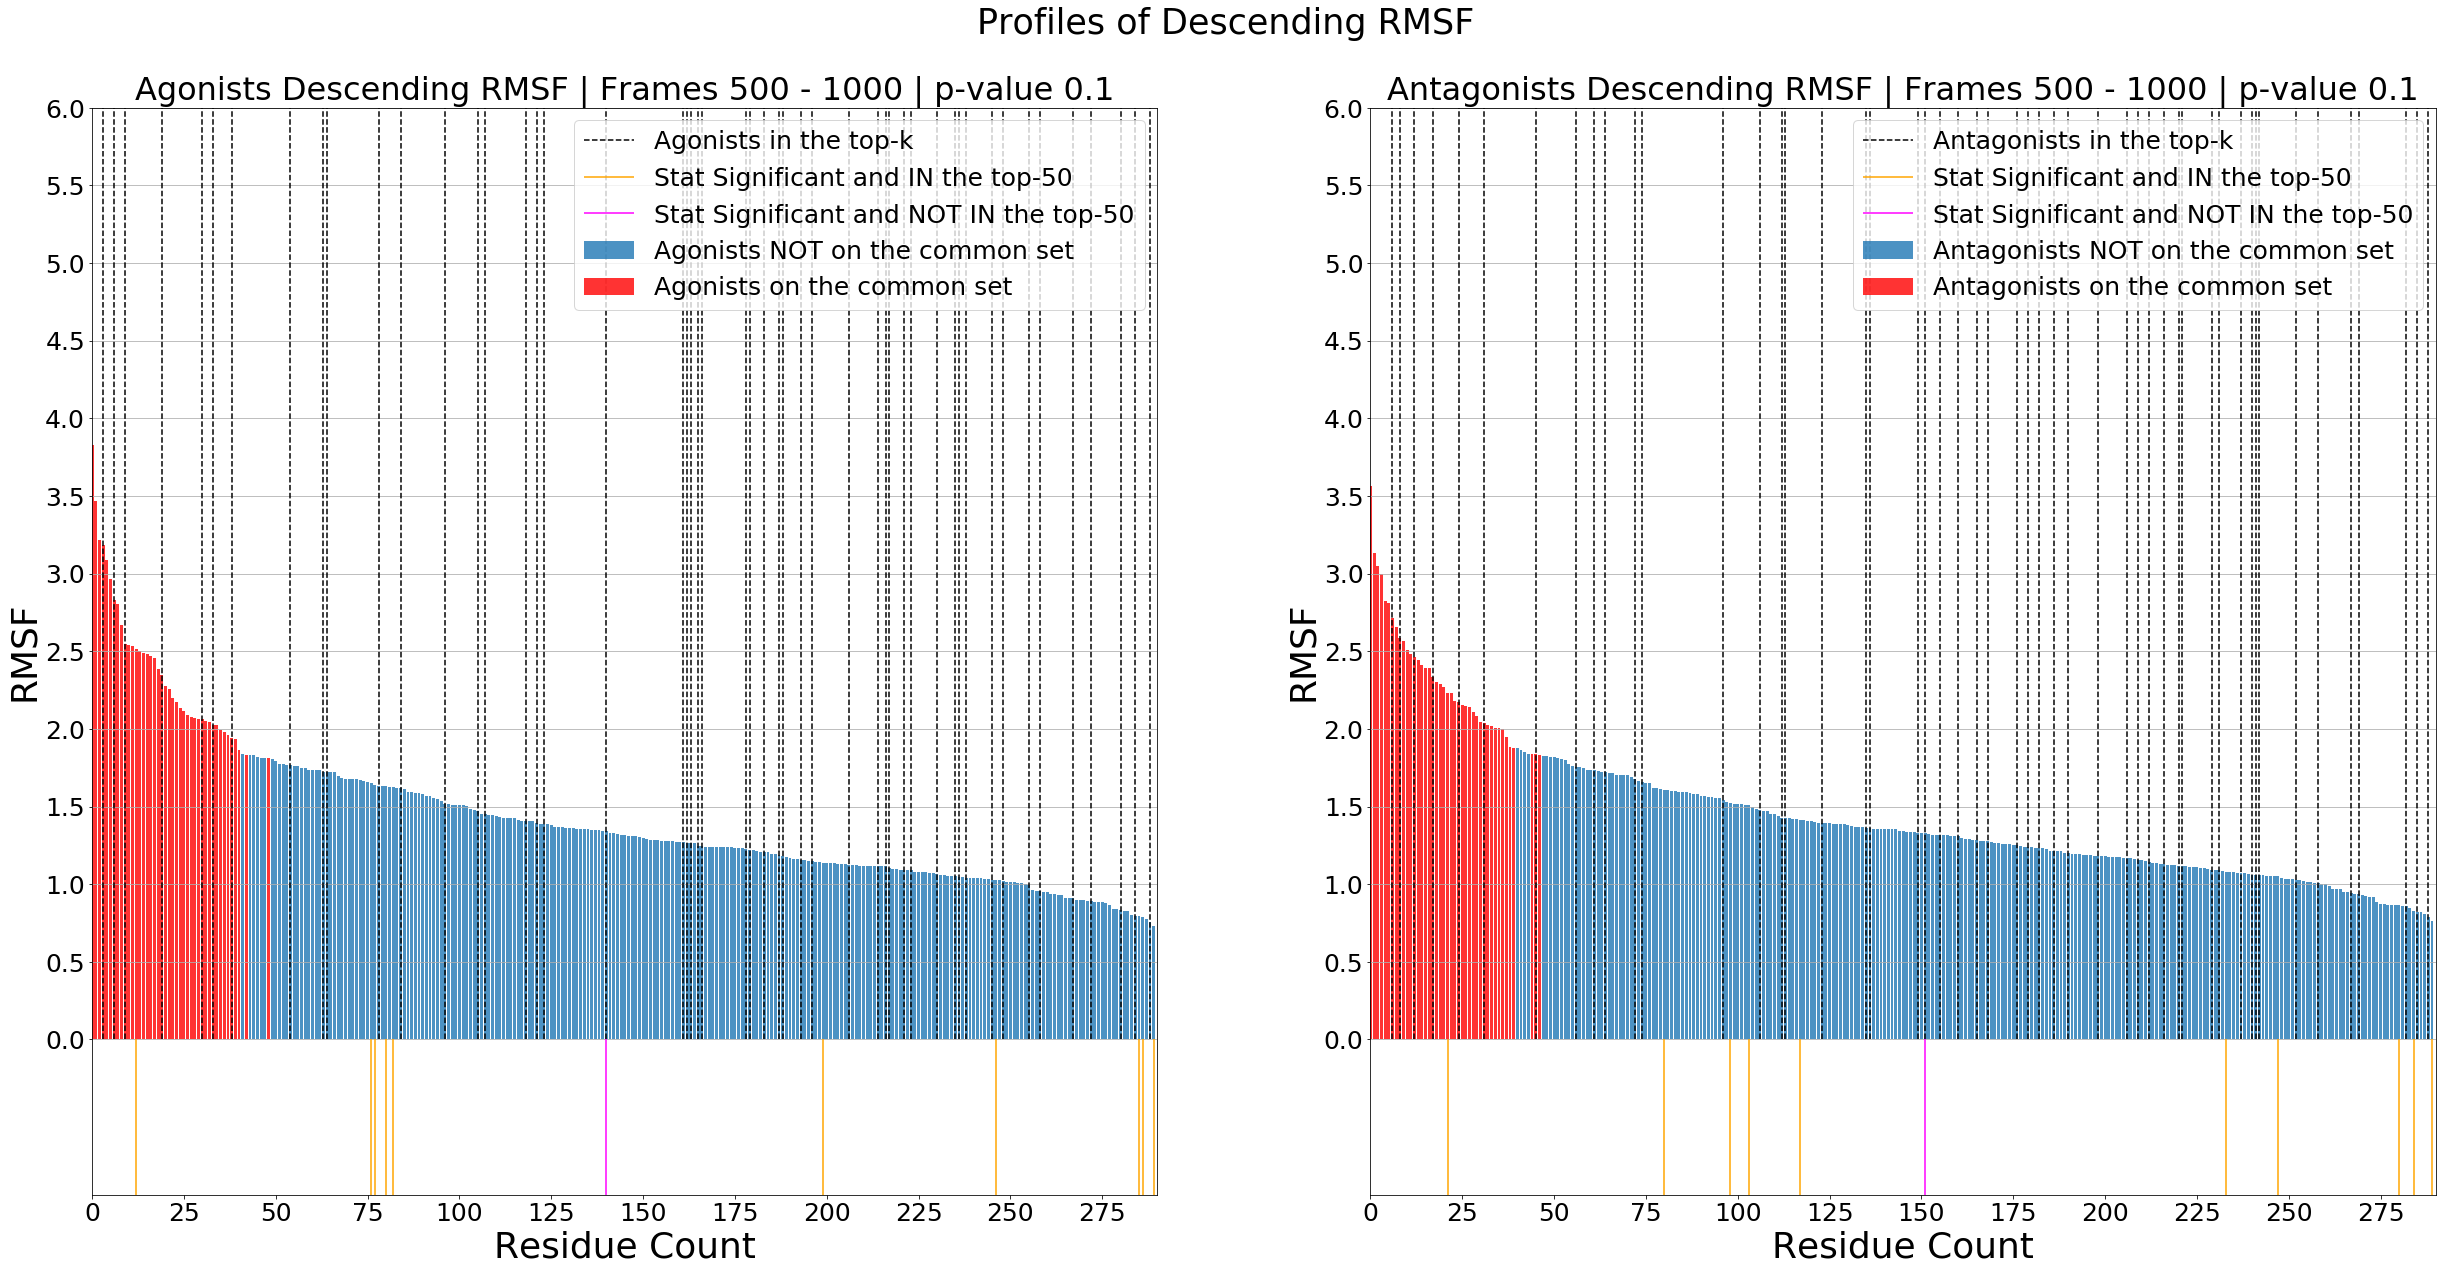

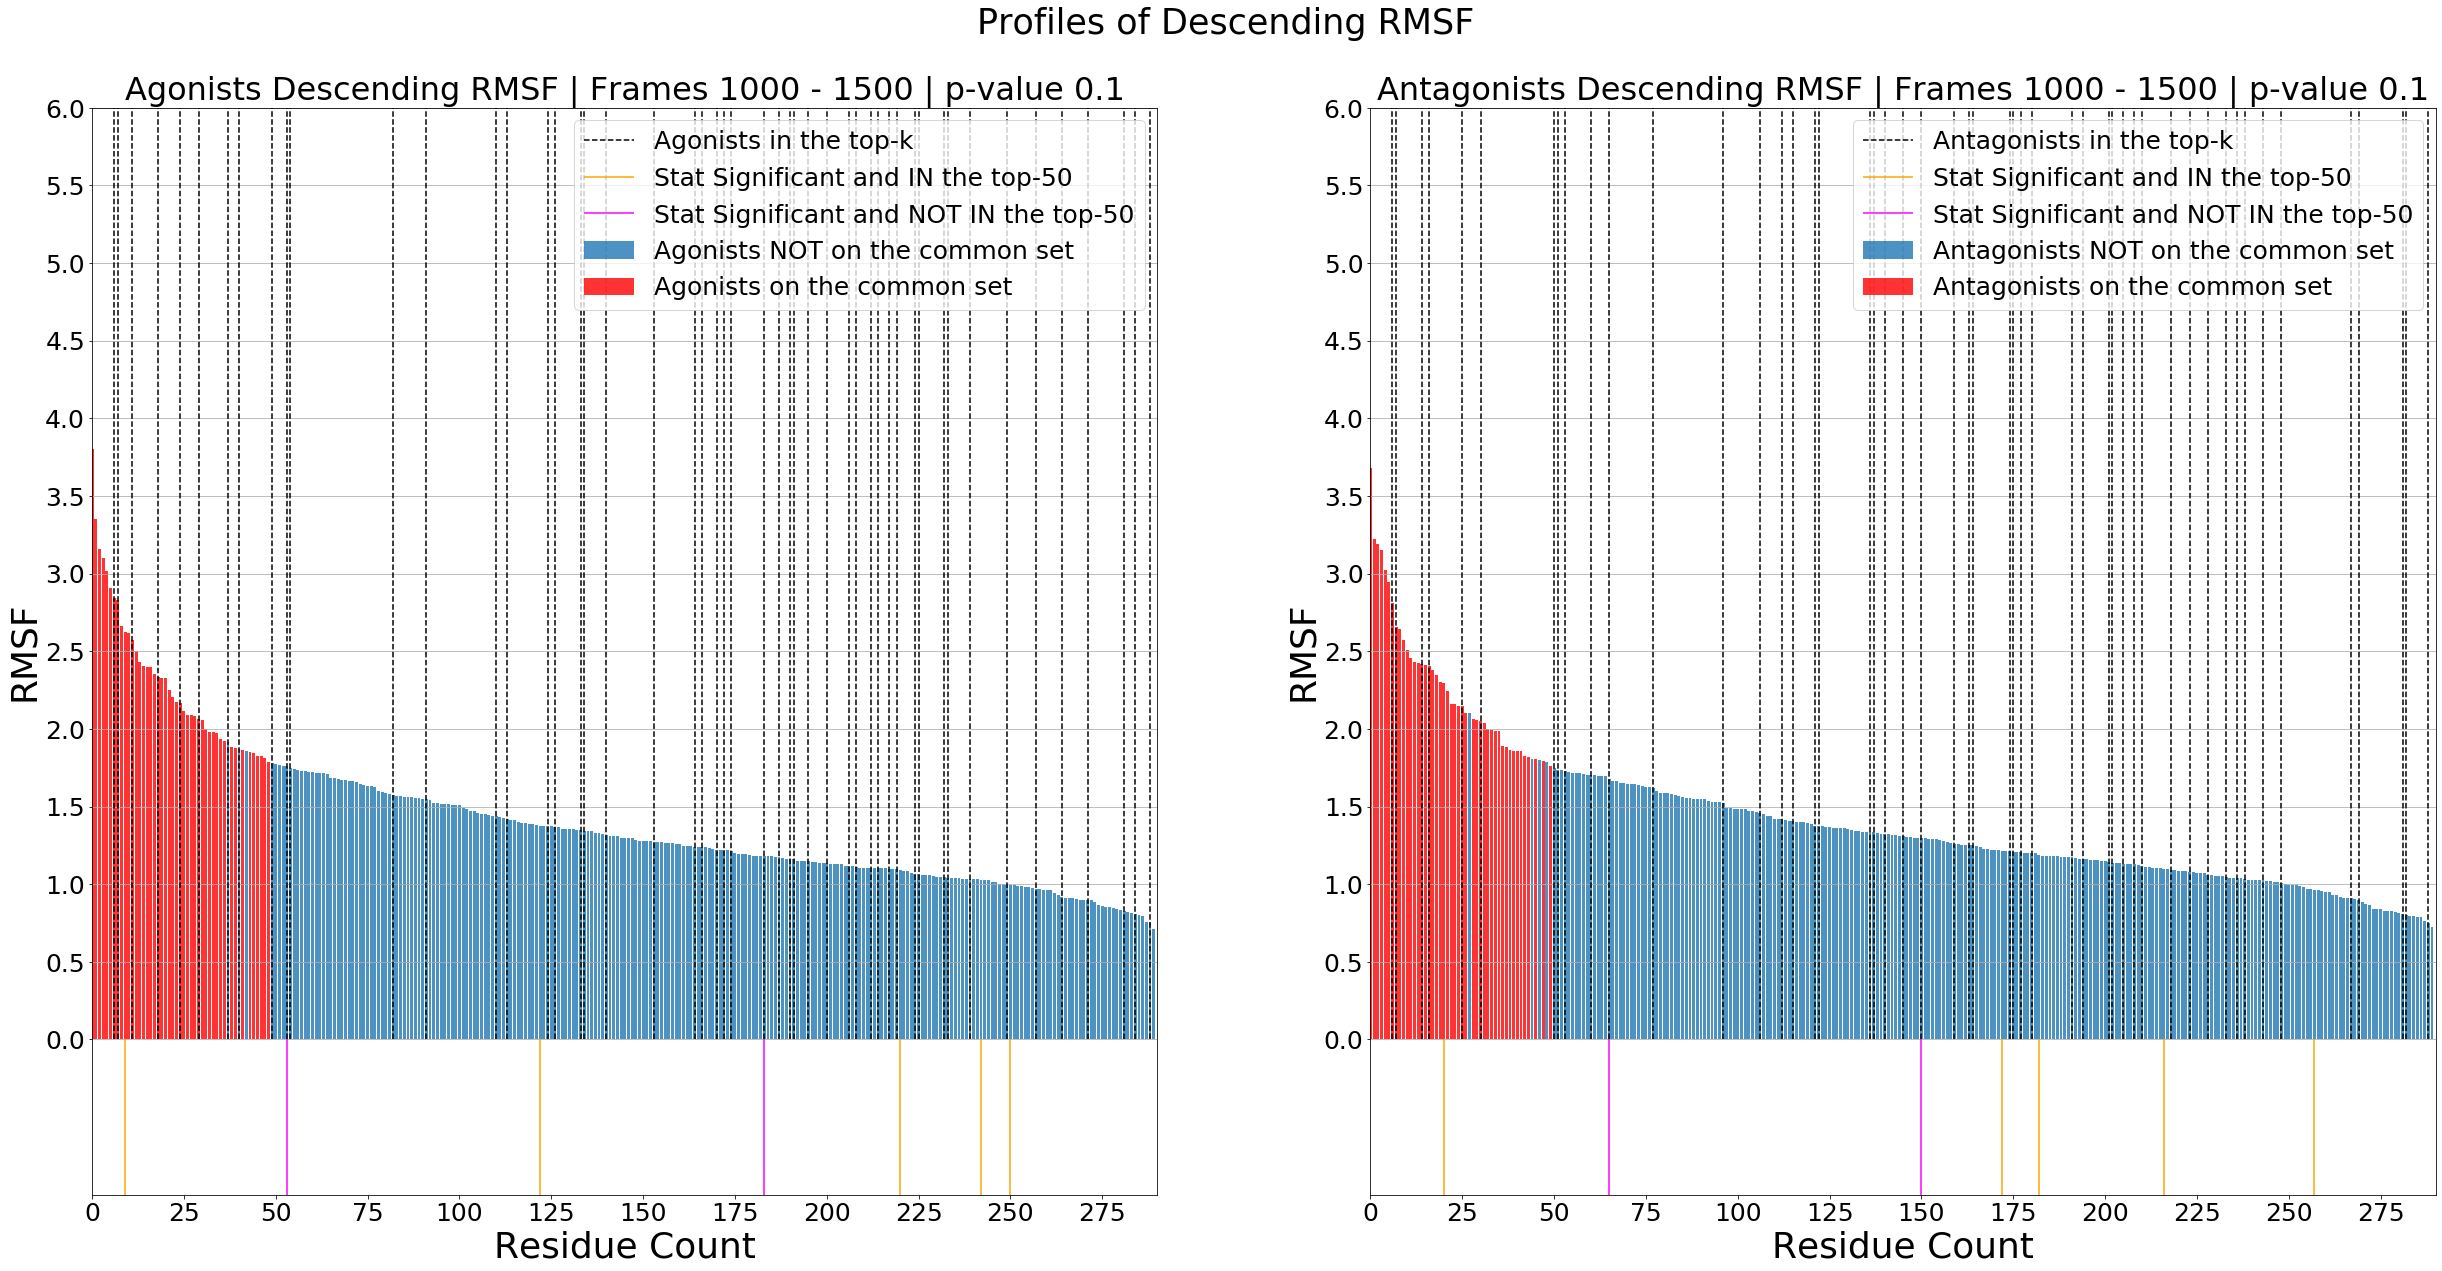

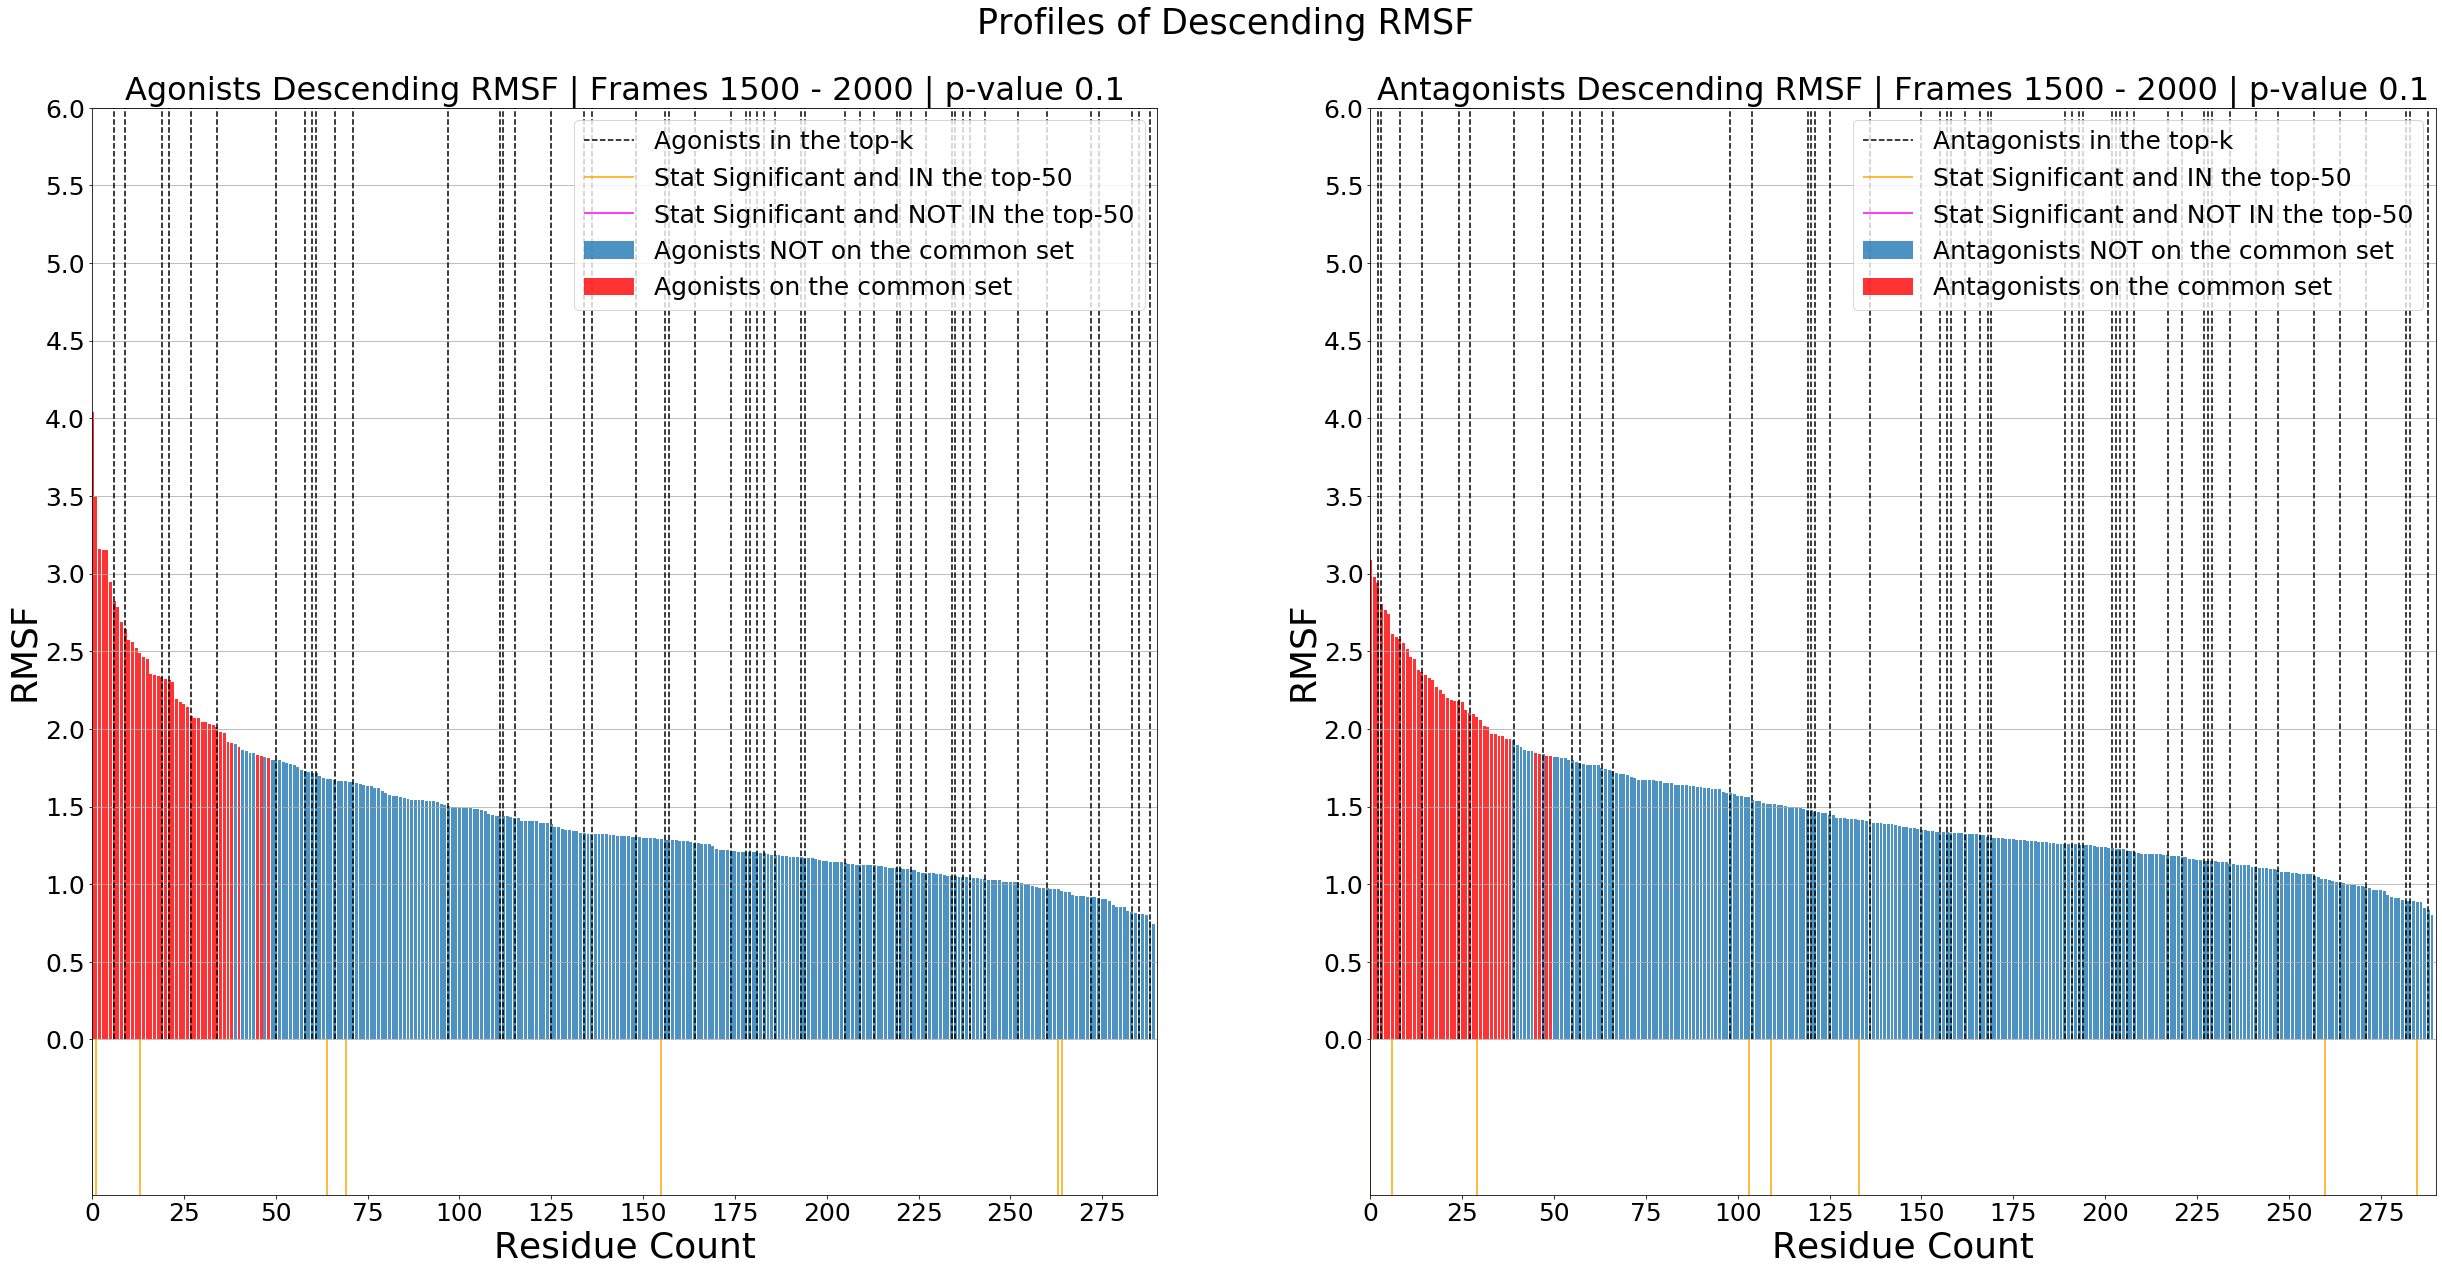

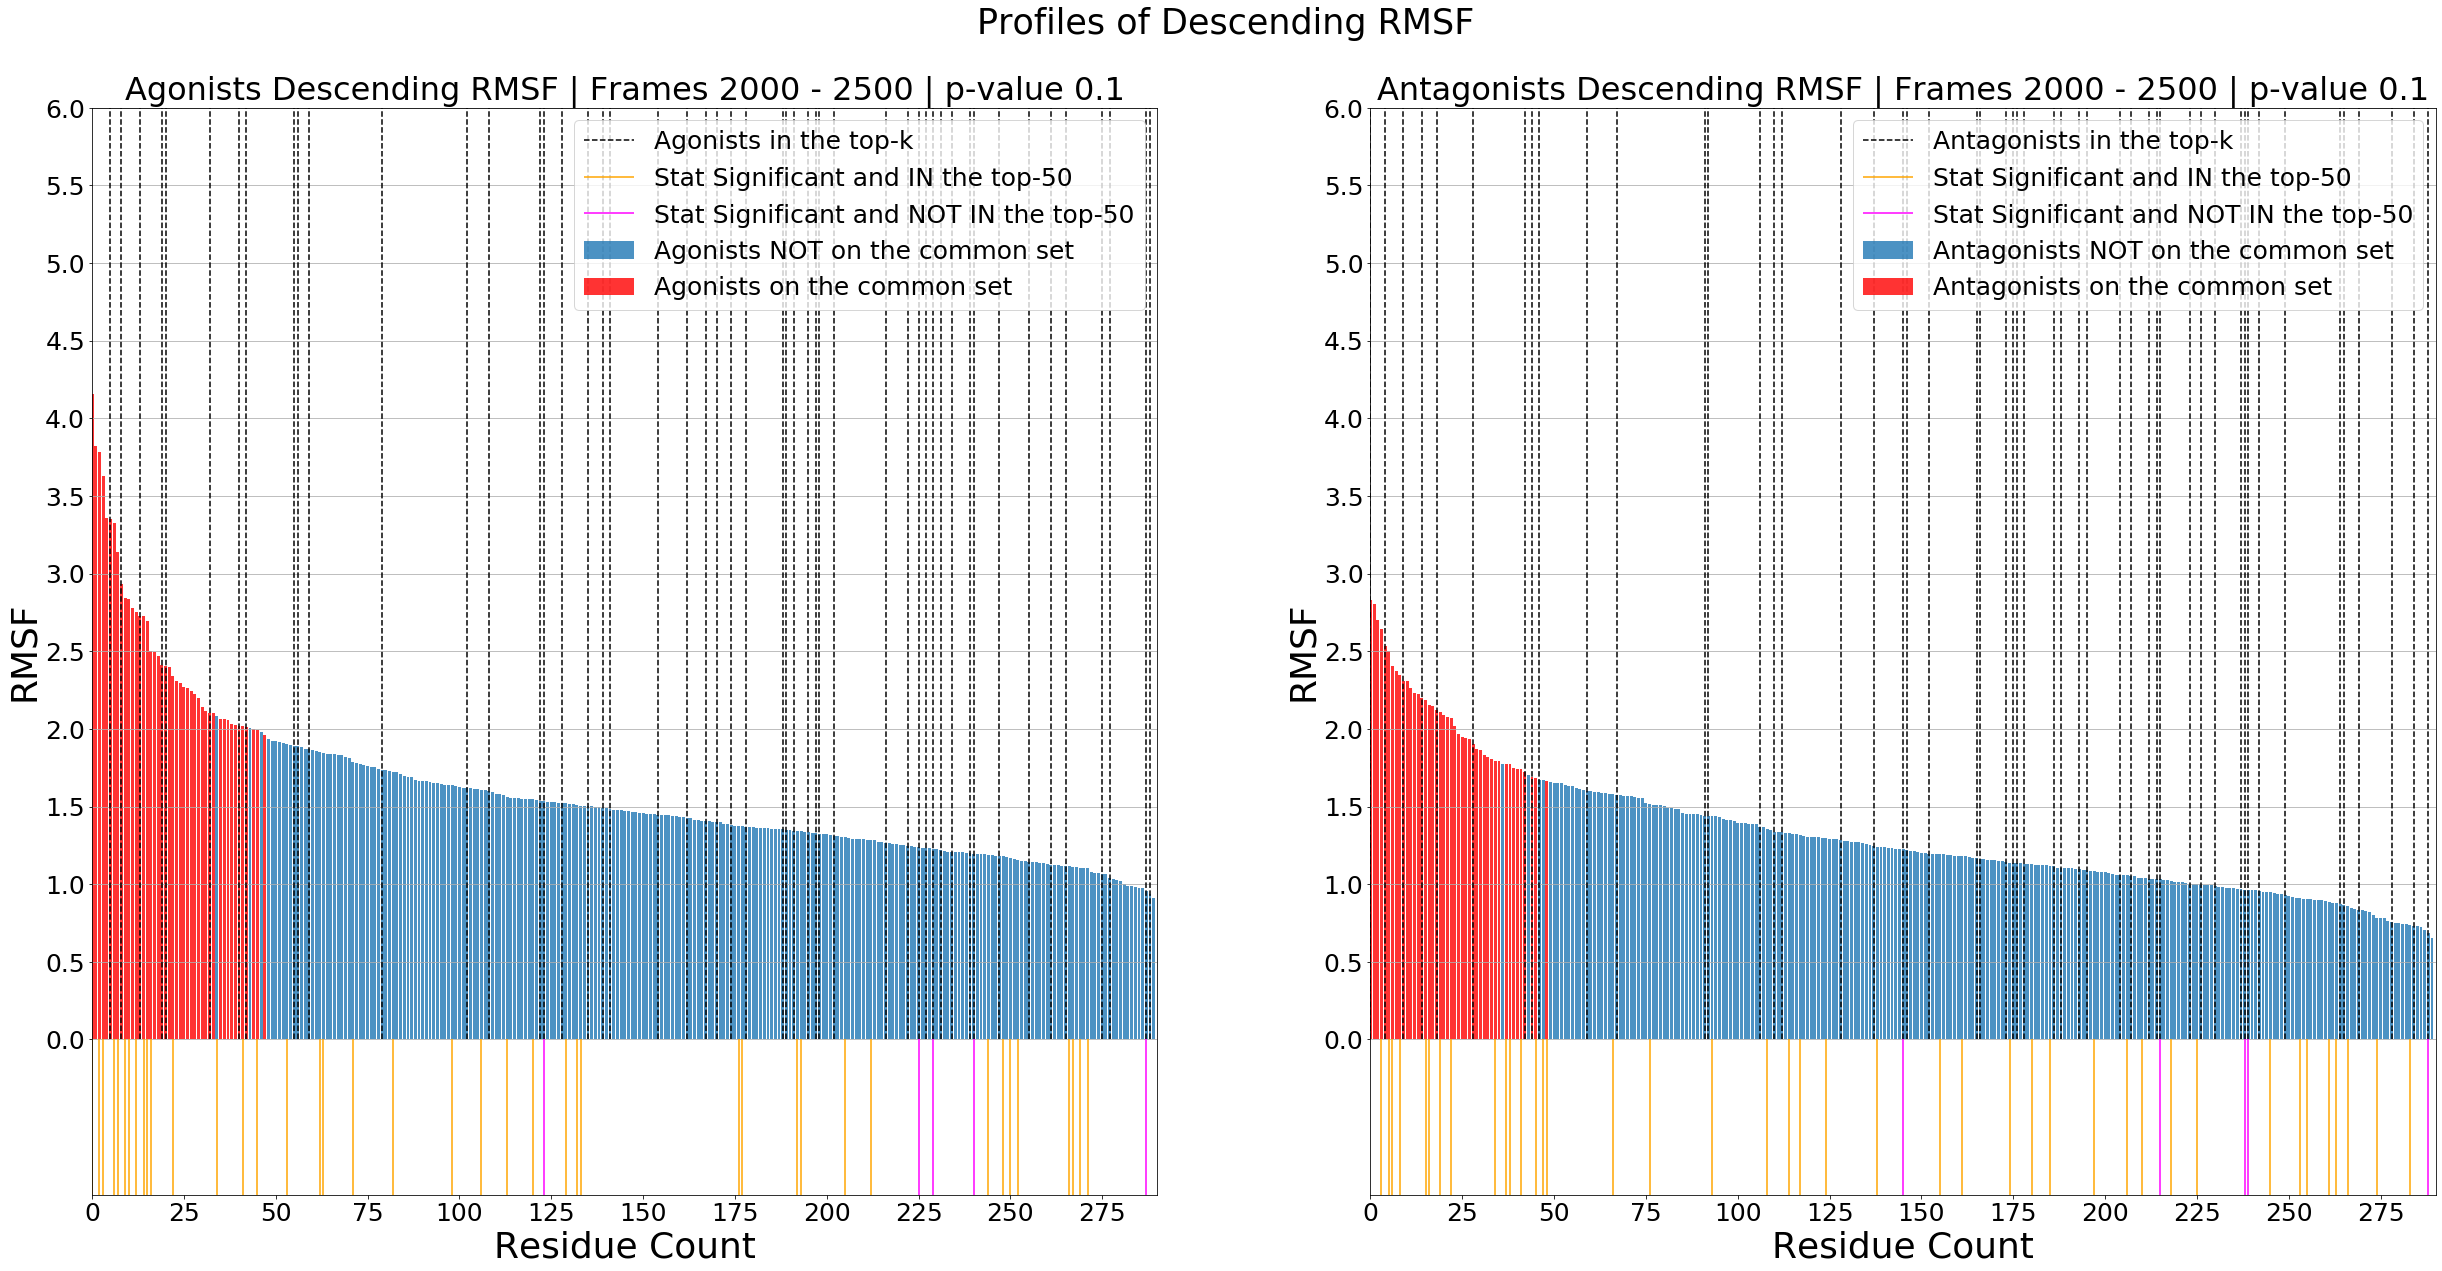

In [22]:
for threshold in [0.05, 0.1]:
    top_k_analysis(analysis_actors_dict, '../figures/RMSF/new/', top=50, start=0, stop=2500, threshold=threshold)
    top_k_analysis(analysis_actors_dict, '../figures/RMSF/new/', top=50, start=0, stop=1250, threshold=threshold)
    top_k_analysis(analysis_actors_dict, '../figures/RMSF/new/', top=50, start=1250, stop=2500, threshold=threshold)

    for start in np.arange(0, 2500, 500):
        top_k_analysis(analysis_actors_dict, '../figures/RMSF/new/', top=50, start=start, stop=start + 500, threshold=threshold)

### Bootstrap Analysis of Most Significant Residues

The above test gives us the most significant residues but we have no measure of the sensitivity of the significance. Meaning that if we change some ligands on the dataset we want our significant residues to remain the same.  
  
To do that we follow the below bootstrapping method:  
  
1. We pick 20 agonists and 20 antagonists (20 is a parameter and should change if our dataset size increases)
2. We randomly pick 12 agonists and 12 antagonists that will be our starting set. The other 8 and 8 will be our replacement pool.
3. We repeat for a given number of iterations:
    1. Find the union of the most significant residues on specific windows (currently 500 - 1000, 0 - 1500)
    2. Save the most significant residues
    3. Replace 1 agonist and 1 antagonist with a random ligand from their respective replacement pools
4. Calculate the sensitivity of the results

In [6]:
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue

def initialize_pools(ligands_list, total_ligands=20, set_ligands=12):
    """
    Inputs a list of ``MDSimsEval.AnalysisActor`` objects and returns initial input and replacement 
    sets of the given size.
    
    Args:
        ligands_List: List of ``MDSimsEval.AnalysisActor`` objects
        total_ligands(int): How many ligands will be used in the experiment (input + replacement sets sizes)
        set_ligands(int): How many ligands will be on the initial input set. The rest of them will be on the
        replacement set
        
    Returns:
        | Tuple of (List of ``MDSimsEval.AnalysisActor`` that will be our initial input set,
        |           List of ``MDSimsEval.AnalysisActor`` that will be our initial replacement set)

    """
    ligands_chosen = random.sample(ligands_list, total_ligands)
    
    chosen_random_ligands = random.sample(list(np.arange(len(ligands_chosen))), set_ligands)
    mask_set_ligands = np.array([which_lig in chosen_random_ligands
                      for which_lig in np.arange(total_ligands)])
    
    return list(np.array(ligands_chosen)[mask_set_ligands]), list(np.array(ligands_chosen)[~mask_set_ligands])
    
def replacement_swap(input_set, replacement_set, numb_of_replacements=1):
    """
    Performs given number of swaps between the input_set and the replacement_set.The swaps are inplace.
    
    Args:
        input_set: List of ``MDSimsEval.AnalysisActor`` that is our input set 
        replacement_set: List of ``MDSimsEval.AnalysisActor`` that is our replacement set
        
    """
    to_be_replaced_indexes = random.sample(list(np.arange(len(input_set))), numb_of_replacements)
    to_be_inputted_indexes = random.sample(list(np.arange(len(replacement_set))), numb_of_replacements)
    
    
    for replaced, inputted in zip(to_be_replaced_indexes, to_be_inputted_indexes):
        input_set[replaced], replacement_set[inputted] = replacement_set[inputted], input_set[replaced]
        
    return None

def minimal_stat_test(agons, antagons, stat_test, start, stop, threshold=0.05):
    """
    Inputs a list of agonists and a list of antagonists and finds the most significant residues. We do not return
    the p_value but only the residue ids.
    
    .. todo::

         RMSF calcualtions get repeated. I should in the near feature create a caching mechanism.
    
    Args:
        agons: List of ``MDSimsEval.AnalysisActor`` agonists
        antagons: List of ``MDSimsEval.AnalysisActor`` antagonists
        stat_test (scipy.stats): A statistical test method with the interface of scipy.stats methods
        start(int): The starting frame of the calculations
        stop(int): The stopping frame of the calculations
        threshold (float): The p-value threshold of the accepted and returned residues

        
    """
    reset_rmsf_calculations({'Agonists':agons, 'Antagonists':antagons}, start=start, stop=stop)
    
    stacked_agons_rmsf = np.array([get_avg_rmsf_per_residue(ligand) for ligand in agons])
    stacked_antagons_rmsf = np.array([get_avg_rmsf_per_residue(ligand) for ligand in antagons])
    
    # Get the p_value of each residue
    p_values = []
    for agon_res_rmsf, antagon_res_rmsf in zip(stacked_agons_rmsf.T, stacked_antagons_rmsf.T):
        p_values.append(stat_test(agon_res_rmsf,antagon_res_rmsf)[1])
        
    # Select the p_values that pass the threshold
    enumed_pvalues = np.array(list(enumerate(p_values)))
    enumed_pvalues = enumed_pvalues[enumed_pvalues[:, 1] <= threshold]
    
    return set(enumed_pvalues[:,0])

In [44]:
def bootstrapped_residue_analysis(analysis_actors_dict, windows, stat_test, threshold, input_size, replacement_size, iterations, replacements):
    """
    | This is the main method of finding the most significant RMSF residues in a general enough way in order to avoid
      overfitting.
    | To do that we follow the below bootstrapping method:  
  
    1. We pick ``input_size + replacement_size`` agonists and ``input_size + replacement_size`` antagonists
    2. We randomly pick ``input_size`` agonists and ``input_size`` antagonists that will be our input set.
    3. We repeat for a given number of iterations:
        1. Find the union of the most significant residues on specific windows
        2. Save the most significant residues
        3. Replace 1 agonist and 1 antagonist with a random ligand from their respective replacement pools
    4. Return the sensitivity of the results
    
    The returned sensitivity of each residue is calculated by calculating ``residue_appearances / iterations``.
    
    Args:
        analysis_actors_dict: ``{ "Agonists": List[AnalysisActor.class], "Antagonists": List[AnalysisActor.class] }``
        windows: List of (start, stop) tuples of each window
        stat_test (scipy.stats): A statistical test method with the interface of scipy.stats methods
        threshold (float): The p-value threshold of the accepted and returned residues
        input_size (int): The size of set for each class on which we will find the significant residues
        replacement_size (int): The size of the replacement set for each class
        iterations(int): How many times we will repeat the finding of the significant residues
    
    Returns: A dictionary of ``{ResidueId: Sensitivity}`` for all the residues that appeared at least on one iteration
        
    
    """
    # Create our initial input and replacement set for both agonist and antagonists
    inp_set_agon, rep_set_agon = initialize_pools(analysis_actors_dict['Agonists'], 
                                                  total_ligands=input_size + replacement_size, set_ligands=input_size)
    inp_set_antagon, rep_set_antagon = initialize_pools(analysis_actors_dict['Antagonists'], 
                                                        total_ligands=input_size + replacement_size, set_ligands=input_size)
    
    significant_residues_per_iter = []
    
    for i in tqdm(range(iterations), desc='Iterations'):
        iteration_residues = []
        for start, stop in windows:
            sign_residues = minimal_stat_test(inp_set_agon, inp_set_antagon, stat_test, start, stop, threshold)
            iteration_residues.append(sign_residues)
            
        
        # Extract the union of the significant residues from all the windows
        significant_residues_per_iter.append(set().union(*iteration_residues))
        
        
        # Perform the replacement of our bootstrap method
        replacement_swap(inp_set_agon, rep_set_agon, replacements)
        replacement_swap(inp_set_antagon, rep_set_antagon, replacements)
        
    # Calculate the sensitivity of each significant residue
    return significant_residues_per_iter

In [33]:
with open(r"cache/rmsf_pre_calc_samples_1.pkl", "rb") as input_file:
    res = pickle.load(input_file)

# print(res)

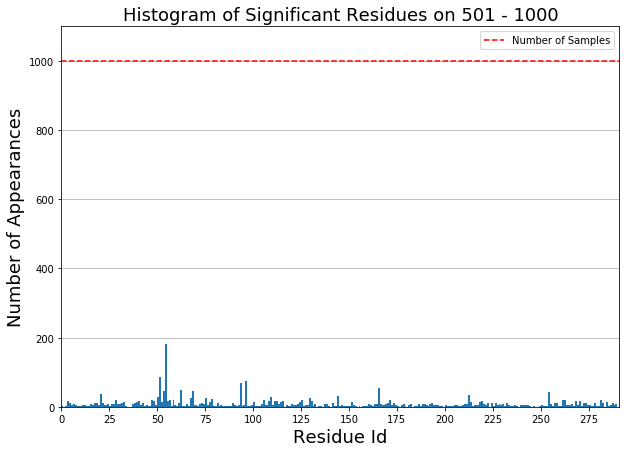

In [25]:
# res_list = [[k, v] for k,v in res.items()]

# # print(sorted(res_list, key=lambda x: x[1], reverse=True))
# print(pd.DataFrame(sorted(res_list, key=lambda x: x[1], reverse=True)).iloc[:10])
# print(res)

# Flattened_residues
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

flat_res = [residue for iteration_residues in res for residue in iteration_residues]
# print(flat_res)
plt.hist(flat_res, bins=np.arange(292))


plt.xlabel("Residue Id", fontsize=18)
plt.ylabel("Number of Appearances", fontsize=18)

plt.title("Histogram of Significant Residues on 501 - 1000", fontsize=18)
plt.xlim(0, 291)
plt.xticks(np.arange(0, 292, 25))
plt.ylim(0, 1100)

ax.yaxis.grid()

plt.hlines(y=1000, xmin=0, xmax=291, color='red', linestyles='dashed', label="Number of Samples")

plt.legend()
plt.savefig('../figures/RMSF/new/rmsf_sign_hist_500_1000_samples_1000.png', format='png')

plt.show()

In [40]:
def sensitivity_calc(sign_residues_per_iter):
    sens_dict = {}
    for which_iter in sign_residues_per_iter:
        for which_res in which_iter:
            try:
                sens_dict[which_res] += 1
            except KeyError:
                sens_dict[which_res] = 1
                
    # Get the sensitivity by calculating residue_appearances / total_iterations
    sens_dict = {k: v / len(sign_residues_per_iter) for k, v in sens_dict.items()}
    
    return sens_dict

sensitivity_calc([{48.0, 105.0, 50.0, 115.0, 96.0, 51.0, 53.0, 54.0, 41.0}, {96.0, 225.0, 89.0, 41.0, 171.0, 47.0, 48.0, 50.0, 115.0, 51.0, 181.0, 118.0, 55.0, 20.0, 54.0, 93.0}])

{96.0: 1.0,
 105.0: 0.5,
 41.0: 1.0,
 48.0: 1.0,
 50.0: 1.0,
 115.0: 1.0,
 51.0: 1.0,
 53.0: 0.5,
 54.0: 1.0,
 225.0: 0.5,
 171.0: 0.5,
 47.0: 0.5,
 181.0: 0.5,
 118.0: 0.5,
 55.0: 0.5,
 20.0: 0.5,
 89.0: 0.5,
 93.0: 0.5}

### Bootstrap Analysis - Pre Calculated Bootstrap Samples

In [13]:
from MDSimsEval.rmsf_bootstrapped_analysis import minimal_stat_test

def bootstrap_rmsf_pre_calc_samples(analysis_actors_dict, start, stop, stat_test, threshold, samples_numb, sample_size):
    # Create the samples
    samples = []
    for i in range(samples_numb):
        samples.append(
            {'Agonists':random.sample(analysis_actors_dict['Agonists'], sample_size),
             'Antagonists':random.sample(analysis_actors_dict['Antagonists'], sample_size)}
        )
    
    rmsf_cache = {}
    residues_per_sample = []
    
    for sample in tqdm(samples, desc='Sample'):
        sign_residues = minimal_stat_test(sample['Agonists'], sample['Antagonists'], stat_test, start, stop, threshold, rmsf_cache)
    
        residues_per_sample.append(set(sign_residues))
    
    return residues_per_sample

res = bootstrap_rmsf_pre_calc_samples(analysis_actors_dict, 0, 500, stats.ks_2samp, 0.05, 3, 10)

In [49]:
from MDSimsEval.rmsf_analysis import get_avg_rmsf_per_residue
from MDSimsEval.rmsf_analysis import reset_rmsf_calculations

def create_correlation_df(analysis_actors_dict, residue_ids, method, start, stop, rmsf_cache=None):
    """
    Creates a ``numb_of_ligands x numb_of_ligands`` dataframe which has the pair correlations calculated
    on the rmsf of the given ``residue_ids``.
    
    The result is not in a readable format and should be passed in ``TODO``.
    
    Args:
        analysis_actors_dict: ``{ "Agonists": List[AnalysisActor.class], "Antagonists": List[AnalysisActor.class] }``
        residue_ids: List of residue ids that we want to use in order to calculate the calculations.
        Eg the top-k, high-k, most statistically significant.
        method (str): pearson, kendall, spearman
        start(int): The starting frame of the calculations
        stop(int): The stopping frame of the calculations
        rmsf_cache: Dictionary with key ``ligand_name_start_stop`` and value the RMSF run result. If set 
        to ``None`` no cache will be kept
        
    Returns:
        A ``pd.DataFrame`` which has the pair correlations of all the ligands
        
    """
    reset_rmsf_calculations(analysis_actors_dict, start, stop, rmsf_cache)
    
    # Calculating the RMSFs of each residue instead of each atom
    residue_rmsfs_agon = np.array([get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Agonists']])
    residue_rmsfs_antagon = np.array([get_avg_rmsf_per_residue(ligand) for ligand in analysis_actors_dict['Antagonists']])
    
    # We need the number of total residues to create the mask below
    residues_numb = len(residue_rmsfs_agon[0])
    
    # Create a True, False mask of the given residues
    top_mask = [res_id in residue_ids for res_id in np.arange(residues_numb)]
    
    # Creating a DataFrame which will have as columns the ligand names and as rows the residues
    rmsf_array = np.array([res_rmsf[top_mask] for res_rmsf in np.vstack((residue_rmsfs_agon, residue_rmsfs_antagon))])
    
    # Use only the first 5 chars of the ligand name for better visual results
    ligand_names = [ligand.drug_name[:5]
                    for ligand in analysis_actors_dict['Agonists'] + analysis_actors_dict['Antagonists']]
    rmsf_df = pd.DataFrame(rmsf_array.T, columns=ligand_names)
    
    # Create the correlation dataframe
    corr = rmsf_df.corr(method=method)
    
    return corr


def render_corr_df(corr_df, filepath):
    """
    Renders and saves a correlation heatmap which visually interpretable.
    
    .. figure:: ../_static/rmsf_corr.png
        :width: 600px
        :align: center
        :height: 250px
        :alt: rmsf corr figure missing

        Correlation heatmap, click for higher resolution.

    .. note::

         In order to save the as ``.png`` you must install ``wkhtmltopdf`` via ``sudo apt-get install wkhtmltopdf`` on
         your machine. Else the output will be in ``.html`` and can be viewed using any browser.
         
    Args:
        corr_df(pd.DataFrame): A DataFrame of pairwise correlations
        filepath(str): The full path the heatmap save location eg. ``/dir1/dir2/name_of_file``
         
    """
    html_render = corr_df.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2).render()
    
    # Saving the correlation matrix
    try:
        # If wkhtmltopdf is installed save the results as a .png
        imgkit.from_string(html_render, f"{filepath}.png")
    except IOError:
        # Save the html of the correlation map, which can be rendered by a browser
        with open(f"{filepath}.html", "w") as text_file:
            text_file.write(html_render)

def corr_of_significant_residues(analysis_actors_dict, sign_residues, start, stop, top, method='spearman',rmsf_cache=None):
    
    # Flatten the significant residues from a list of sets to a list
    flat_res = [residue for iteration_residues in sign_residues for residue in iteration_residues]
    
    # Find on how many iterations or samples each residue appears as significant
    res_frequencies={}
    for residue in flat_res:
        if residue in res_frequencies:
            res_frequencies[residue] += 1
        else:
            res_frequencies[residue] = 1
    
    res_frequencies = [[res_id, freq] for res_id, freq in res_frequencies.items()]
    
    # Keep only the top residues that have the biggest frequencies
    res_frequencies = sorted(res_frequencies, key=lambda x: x[1], reverse=True)[:top]
    
    # Create a list of the residue ids kept
    top_residues = [res_freq[0] for res_freq in res_frequencies]   
    
    corr = create_correlation_df(analysis_actors_dict, top_residues, method, start, stop, rmsf_cache)
    
    render_corr_df(corr, '../figures/RMSF/new/name_of_file')
    
#     return corr

    
corr_of_significant_residues(analysis_actors_dict, res, 0, 500, 50)

Qt: Session management error: Could not open network socket
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
